In [1]:
import pandas as pd
import numpy as np
import xarray as xr
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['savefig.dpi'] = 400
%config InlineBackend.figure_format = 'retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import os
from os import listdir
# os.environ["NUMBA_NUM_THREADS"] = "1"
import json
import random
random.seed(42)
np.random.seed(42)

In [2]:
dir = os.path.dirname(os.path.abspath('__file__')) # os.path.abspath('')
data_path = os.path.join(dir, '../data/raw')
pro_data_path = os.path.join(data_path, '../processed')
res_path = os.path.join(dir, '../results')
plot_path = os.path.join(dir, '../figures')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
ana_path = os.path.join(res_path, 'analysis')
if not os.path.exists(ana_path):
    os.makedirs(ana_path)
model_path = os.path.join(res_path, 'models')

train_path = os.path.join(res_path, "train")

In [3]:
# Load data
lbl_2_idx = np.load(os.path.join(pro_data_path, "lbl_2_idx.npy"), allow_pickle=True)
lbl_2_idx = dict(lbl_2_idx.tolist())
idx_2_lbl = np.load(os.path.join(pro_data_path, "idx_2_lbl.npy"), allow_pickle=True)
idx_2_lbl = dict(idx_2_lbl.tolist())

In [4]:
# Model
import torch.nn as nn
import torch.nn.functional as F
import torch

class CirculationTypeClassifier(nn.Module):
    def __init__(self, num_classes, lat, lon, dropout_rate=0.3, out_channels1=8, out_channels2=16, kernel_size=5, fc1_size=50):  # 2 channels (SLP & Z500)
        super(CirculationTypeClassifier, self).__init__()

        self.lat = lat
        self.lon = lon
        padding = kernel_size // 2
      
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=out_channels1, kernel_size=kernel_size, stride=1, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.conv2 = nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, kernel_size=kernel_size, stride=1, padding=padding)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(self._calculate_fc_input_size(), fc1_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc1_size, num_classes)
        
    def _calculate_fc_input_size(self):
        # Helper function to calculate the input size for the first fully connected layer
        with torch.no_grad():
            x = torch.zeros(1, 2, self.lat, self.lon)
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = self.flatten(x)
            return x.shape[1]
    
    def forward(self, x):
        # Forward pass
        x = F.relu(self.conv1(x))  # Assuming ReLU activation
        x = self.pool1(x)
        x = F.relu(self.conv2(x))  # Assuming ReLU activation
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))  # Assuming ReLU activation
        x = self.dropout(x)
        x = self.fc2(x)  # Assuming no activation function for the output layer
        return x

In [5]:
# predict use saved ensemble models
import re
import glob

model_path = os.path.join(res_path, 'models')

def predict(X, model_path, fold=5, ensemble=30, num_classes=29, each_ensemble=False):
    ensemble_per_fold = ensemble // fold
    lat = X.shape[2]
    lon = X.shape[3]
    assert X.shape[1] == 2, "Input data must have 2 channels (SLP and Z500)"
    assert (lat, lon) == (10, 23), "Input data must have same grids as training data"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = torch.tensor(X, dtype=torch.float32).to(device)

    ensemble_predictions = []
    for fold_idx in range(fold):
        for esb_idx in range(ensemble_per_fold):
            p_path = os.path.join(model_path, f"params_f{fold_idx}_e{esb_idx}.json")
            with open(p_path, "r") as f:
                params = json.load(f)
            model = CirculationTypeClassifier(num_classes, lat, lon, 
                                              dropout_rate=params['dropout'], 
                                              out_channels1=params['out_channels1'],
                                              out_channels2=params['out_channels2'],
                                              kernel_size=params['kernel_size'],
                                              fc1_size=params['fc1_size']).to(device)
            
            m_path = os.path.join(model_path, f"model_f{fold_idx}_e{esb_idx}.pt")
            model.load_state_dict(torch.load(m_path, map_location=device))
            _= model.eval()

            with torch.no_grad():
                outputs = model(X)
                probs = F.softmax(outputs, dim=1).cpu().numpy()  # softmax output
                ensemble_predictions.append(probs)

    ensemble_predictions = np.array(ensemble_predictions)  # (n_models, n_samples, n_classes)
    avg_softmax = np.mean(ensemble_predictions, axis=0)    # (n_samples, n_classes)
    final_preds = avg_softmax.argmax(axis=1)

    if each_ensemble:
        return ensemble_predictions, final_preds, avg_softmax  # all models' probs, label and prob
    else:
        return final_preds, avg_softmax  # both label and prob

In [6]:
def transition_smoothing(preds, probs, min_duration=3, min_neighbor_run_length=2):
    """
    Post-processing smoothing of predicted label sequence.
    Reassigns short-duration segments (< min_duration) based on neighbor consistency
    or estimated class probabilities (from label frequencies).

    Parameters:
    - preds: list or np.ndarray of predicted class labels (after model inference)
    - min_duration: minimum number of days a label must persist
    - min_neighbor_run_length: minimum run length required to trust a neighbor (default: 2)

    Returns:
    - smoothed: np.ndarray of same shape with smoothed label sequence
    """
    preds = np.array(preds)
    smoothed = preds.copy()

    i = 0
    # skip smoothing for the first segment
    current = preds[0]
    while i < len(preds) and preds[i] == current:
        i += 1
            
    while i < len(preds):
        current = preds[i]
        run_length = 1
        while i + run_length < len(preds) and preds[i + run_length] == current:
            run_length += 1

        if run_length < min_duration:
            start = i
            end = i + run_length
            prev_label = preds[start - 1] if start > 0 else None
            next_label = preds[end] if end < len(preds) else None

            # Check if it's the last segment
            is_last_segment = end == len(preds)
            if is_last_segment:
                if prev_label == current:
                    # Only smooth if consistent with previous
                    smoothed[start:end] = prev_label
                i += run_length
                continue

            if prev_label == next_label and prev_label is not None:
                smoothed[start:end] = prev_label
            elif prev_label is not None and next_label is not None:
                # count length of neighbor blocks
                len_prev = 1
                j = start - 1
                while j > 0 and preds[j - 1] == prev_label:
                    len_prev += 1
                    j -= 1
                len_next = 1
                j = end
                while j + 1 < len(preds) and preds[j + 1] == next_label:
                    len_next += 1
                    j += 1
                # use softmax if available and both sides long enough
                if len_prev >= min_neighbor_run_length and len_next >= min_neighbor_run_length:
                    p_prev = probs[start:end, prev_label].mean()
                    p_next = probs[start:end, next_label].mean()
                    smoothed[start:end] = prev_label if p_prev >= p_next else next_label
                else:
                    # fallback to trusted neighbor only
                    if len_prev >= min_neighbor_run_length and len_next < min_neighbor_run_length:
                        smoothed[start:end] = prev_label
                    elif len_next >= min_neighbor_run_length and len_prev < min_neighbor_run_length:
                        smoothed[start:end] = next_label
            elif prev_label is not None:
                smoothed[start:end] = prev_label
            elif next_label is not None:
                smoothed[start:end] = next_label

        i += run_length

    return smoothed

In [7]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

def evaluate_metrics(y_true, y_pred, idx_2_lbl):

    label_order = [
        "WA", "WZ", "WS", "WW", "SWA", "SWZ", "NWA", "NWZ", "HM", "BM",
        "TM", "NA", "NZ", "HNA", "HNZ", "HB", "TRM", "NEA", "NEZ", "HFA",
        "HFZ", "HNFA", "HNFZ", "SEA", "SEZ", "SA", "SZ", "TB", "TRW"
    ]

    class_order = np.unique(y_true)
    class_str = list(map(idx_2_lbl.get, class_order))

    conf_matrix = confusion_matrix(y_true, y_pred, labels=class_order)
    TP = np.diag(conf_matrix)
    FP = conf_matrix.sum(axis=0) - TP
    FN = conf_matrix.sum(axis=1) - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    precision = np.where((TP + FP) > 0, TP / (TP + FP), 0) * 100  # Avoid division by zero
    recall = np.where((TP + FN) > 0, TP / (TP + FN), 0) * 100
    f1_scores = np.where((precision + recall) > 0, 2 * (precision * recall) / (precision + recall), 0)
    acc_per_class = np.where((TP + FP + FN + TN) > 0, (TP + TN) / (TP + FP + FN + TN), 0) * 100


    df_metrics = pd.DataFrame({
        "Class": class_str,
        "Accuracy": np.round(acc_per_class, 2),
        "Precision": np.round(precision, 2),
        "Recall": np.round(recall, 2),
        "F1-Score (Macro)": np.round(f1_scores, 2),
        "F1-Score (Weighted)": np.round(f1_scores, 2)
    })
    df_metrics = df_metrics.set_index("Class")
    df_metrics = df_metrics.loc[label_order]


    bal_acc = balanced_accuracy_score(y_true, y_pred) * 100
    pre = np.mean(precision)
    rec = np.mean(recall)
    f1_mac = f1_score(y_true, y_pred, average="macro") * 100
    f1_wei = f1_score(y_true, y_pred, average="weighted") * 100
    df_metrics.loc["General"] = [np.round(bal_acc, 2), np.round(pre, 2), np.round(rec, 2), np.round(f1_mac, 2), np.round(f1_wei, 2)]

    df_conf_matrix = pd.DataFrame(conf_matrix, index=class_str, columns=class_str)
    df_conf_matrix.loc["∑"] = df_conf_matrix.sum(axis=0)
    df_conf_matrix["∑"] = df_conf_matrix.sum(axis=1).values
    df_conf_matrix.loc["Recall"] = np.append(np.round(recall/100, 2), np.round(rec/100,2))
    df_conf_matrix["Precision"] = np.append(np.round(precision/100, 2), [np.round(pre/100,2), np.nan])

    df_conf_matrix = df_conf_matrix.loc[label_order+["∑", "Recall"]]
    df_conf_matrix = df_conf_matrix[label_order+["∑", "Precision"]]

    return df_conf_matrix, df_metrics

In [8]:
def compute_signature(data_path, y_true, y_pred, y_idx, num_classes=29):
    """
    Compute signature plots for SLP and Z500 based on true and predicted labels.

    Returns:
        dict: signature plots for SLP and Z500.
    """
    slp = xr.open_dataset(os.path.join(data_path, 'era5_slp.nc'))
    slp = slp['data'].values / 100  # Convert to hPa
    z500 = xr.open_dataset(os.path.join(data_path, 'era5_z500.nc'))
    z500 = z500['data'].values
    z500_mean = np.mean(z500, axis=0)  # First 31 years for reference
    z500_std = np.std(z500, axis=0)
    z500 = (z500 - z500_mean) / z500_std


    sig_true_slp, sig_pred_slp = {}, {}
    sig_fp_slp, sig_fn_slp = {}, {}

    sig_true_z500, sig_pred_z500 = {}, {}
    sig_fp_z500, sig_fn_z500 = {}, {}

    slp = slp[y_idx]
    z500 = z500[y_idx]

    for label in range(num_classes):
        mask_true = (y_true == label)  # True cases
        mask_pred = (y_pred == label)    # Predicted cases
        mask_fp = (y_pred == label) & (y_true != label)  # False Positives
        mask_fn = (y_true == label) & (y_pred != label)  # False Negatives
        # Compute SLP sigs
        if np.sum(mask_true) > 0:
            sig_true_slp[label] = np.mean(slp[mask_true], axis=0)
        else:
            sig_true_slp[label] = np.full((slp.shape[1], slp.shape[2]), np.nan)

        if np.sum(mask_pred) > 0:
            sig_pred_slp[label] = np.mean(slp[mask_pred], axis=0)
        else:
            sig_pred_slp[label] = np.full((slp.shape[1], slp.shape[2]), np.nan)

        if np.sum(mask_fp) > 0:
            sig_fp_slp[label] = np.mean(slp[mask_fp], axis=0)
        else:
            sig_fp_slp[label] = np.full((slp.shape[1], slp.shape[2]), np.nan)

        if np.sum(mask_fn) > 0:
            sig_fn_slp[label] = np.mean(slp[mask_fn], axis=0)
        else:
            sig_fn_slp[label] = np.full((slp.shape[1], slp.shape[2]), np.nan)

        # Compute Z500 sigs
        if np.sum(mask_true) > 0:
            sig_true_z500[label] = np.mean(z500[mask_true], axis=0)
        else:
            sig_true_z500[label] = np.full((z500.shape[1], z500.shape[2]), np.nan)

        if np.sum(mask_pred) > 0:
            sig_pred_z500[label] = np.mean(z500[mask_pred], axis=0)
        else:
            sig_pred_z500[label] = np.full((z500.shape[1], z500.shape[2]), np.nan)

        if np.sum(mask_fp) > 0:
            sig_fp_z500[label] = np.mean(z500[mask_fp], axis=0)
        else:
            sig_fp_z500[label] = np.full((z500.shape[1], z500.shape[2]), np.nan)

        if np.sum(mask_fn) > 0:
            sig_fn_z500[label] = np.mean(z500[mask_fn], axis=0)
        else:
            sig_fn_z500[label] = np.full((z500.shape[1], z500.shape[2]), np.nan)

    return {"sig_true_slp": sig_true_slp, "sig_pred_slp": sig_pred_slp, "sig_fp_slp": sig_fp_slp, "sig_fn_slp": sig_fn_slp,
            "sig_true_z500": sig_true_z500, "sig_pred_z500": sig_pred_z500, "sig_fp_z500": sig_fp_z500, "sig_fn_z500": sig_fn_z500}


def compute_rmse(field_pred, field_true):
    """
    Compute RMSE between two spatial fields.

    Parameters:
    - field_pred: Predicted SLP/Z500 field (lat, lon)
    - field_true: True SLP/Z500 field (lat, lon)

    Returns:
    - RMSE value (float)
    """
    M, N = field_pred.shape  # Get spatial dimensions
    return np.sqrt(np.sum((field_pred - field_true) ** 2) / (M * N))


def compute_rmse_sig(sig_dict, idx_2_lbl, num_classes=29):
    """
    Compute RMSE between true and predicted signature plots.

    Parameters:
        sig_sig_dicttrue (dict): All signature plots for each class.

    Returns:
        dict: RMSE values for each class.
    """
    rmse_pred_slp, rmse_fp_slp, rmse_fn_slp = [], [], []
    rmse_pred_z500, rmse_fp_z500, rmse_fn_z500 = [], [], []
    sig_true_slp = sig_dict["sig_true_slp"]
    sig_pred_slp = sig_dict["sig_pred_slp"]
    sig_fp_slp = sig_dict["sig_fp_slp"]
    sig_fn_slp = sig_dict["sig_fn_slp"]
    sig_true_z500 = sig_dict["sig_true_z500"]
    sig_pred_z500 = sig_dict["sig_pred_z500"]
    sig_fp_z500 = sig_dict["sig_fp_z500"]
    sig_fn_z500 = sig_dict["sig_fn_z500"]

    for label in range(num_classes):
        rmse_pred_slp.append(compute_rmse(sig_pred_slp[label], sig_true_slp[label]))
        rmse_fp_slp.append(compute_rmse(sig_fp_slp[label], sig_true_slp[label]))
        rmse_fn_slp.append(compute_rmse(sig_fn_slp[label], sig_true_slp[label]))
        rmse_pred_z500.append(compute_rmse(sig_pred_z500[label], sig_true_z500[label]))
        rmse_fp_z500.append(compute_rmse(sig_fp_z500[label], sig_true_z500[label]))
        rmse_fn_z500.append(compute_rmse(sig_fn_z500[label], sig_true_z500[label]))

    class_str = list(map(idx_2_lbl.get, range(num_classes)))

    rmse_dict = {
        "Class": class_str,
        "RMSE_pred_slp": np.round(rmse_pred_slp,3), "RMSE_fp_slp": np.round(rmse_fp_slp,3), "RMSE_fn_slp": np.round(rmse_fn_slp,3),
        "RMSE_pred_z500": np.round(rmse_pred_z500,3), "RMSE_fp_z500": np.round(rmse_fp_z500,3), "RMSE_fn_z500": np.round(rmse_fn_z500,3)
    }


    df_rmse = pd.DataFrame(rmse_dict)
    label_order = [
        "WA", "WZ", "WS", "WW", "SWA", "SWZ", "NWA", "NWZ", "HM", "BM",
        "TM", "NA", "NZ", "HNA", "HNZ", "HB", "TRM", "NEA", "NEZ", "HFA",
        "HFZ", "HNFA", "HNFZ", "SEA", "SEZ", "SA", "SZ", "TB", "TRW"
    ]
    df_rmse = df_rmse.set_index("Class")
    df_rmse = df_rmse.loc[label_order]

    return df_rmse

In [9]:
labels = np.load(os.path.join(pro_data_path, "clean_gwl_1950_1980_lbl.npy"))
labels

array(['HM', 'NWZ', 'NWZ', ..., 'WA', 'WA', 'WA'], dtype='<U4')

## ERA5 - cv tests

In [23]:
# Load cv data
cvout_test_preds = np.load(os.path.join(train_path, "cvout_test_preds.npy"), allow_pickle=True)  # nested cv labels
cvout_test_trues = np.load(os.path.join(train_path, "cvout_test_trues.npy"), allow_pickle=True)
print(cvout_test_preds.shape, cvout_test_trues.shape)

train_idx_out = np.load(os.path.join(train_path, "train_idx_out.npy"), allow_pickle=True)
test_idx_out = np.load(os.path.join(train_path, "test_idx_out.npy"), allow_pickle=True)

(11183,) (11183,)


In [29]:
cv_per_class_cfm, cv_per_class_mtc =  evaluate_metrics(cvout_test_trues, cvout_test_preds, idx_2_lbl)
cv_per_class_cfm
cv_per_class_mtc

cv_per_class_cfm.to_csv(os.path.join(ana_path, "cv_confusion.csv"), index=True)
cv_per_class_mtc.to_csv(os.path.join(ana_path, "cv_metrics.csv"), index=True)

WA       WZ      WS      WW     SWA     SWZ     NWA     NWZ  \
WA      350.00   101.00    0.00    3.00   11.00    3.00   10.00   19.00   
WZ       80.00  1260.00   36.00   28.00   15.00   33.00    2.00   59.00   
WS        0.00    83.00  183.00    2.00    1.00   16.00    0.00    6.00   
WW        2.00    54.00    4.00  209.00    5.00    9.00    0.00    2.00   
SWA      15.00    37.00    1.00    5.00  134.00   22.00    0.00    0.00   
SWZ       6.00    74.00    6.00   14.00   28.00  239.00    0.00    5.00   
NWA      20.00     5.00    0.00    0.00    0.00    0.00   74.00   19.00   
NWZ      20.00   103.00    2.00    2.00    0.00    2.00    9.00  302.00   
HM       22.00    25.00    0.00    3.00   14.00    8.00    3.00    4.00   
BM       66.00    25.00    2.00    9.00   11.00    9.00    3.00   28.00   
TM        0.00     4.00    8.00    3.00    0.00    0.00    0.00    3.00   
NA        1.00     4.00    3.00    0.00    0.00    0.00    2.00    4.00   
NZ        1.00    13.00    0.00    0.00    0.00    0.00    2.00   42.00   
HNA       0.00     3.00    1.00    0.00    0.00    0.00    2.00    1.00   
HNZ       0.00     8.00    6.00    0.00    0.00    5.00    0.00    3.00   
HB        3.00     0.00    0.00    0.00    0.00    0.00    7.00   10.00   
TRM       6.00    61.00    5.00    6.00    0.00    5.00    0.00   39.00   
NEA       2.00     2.00    0.00    3.00    0.00    0.00    0.00    2.00   
NEZ       0.00     2.00    0.00    5.00    0.00    0.00    1.00    4.00   
HFA       1.00     2.00    0.00   12.00    3.00    2.00    0.00    1.00   
HFZ       0.00     1.00    1.00    7.00    0.00    1.00    0.00    0.00   
HNFA      0.00     1.00    0.00    0.00    0.00    2.00    1.00    0.00   
HNFZ      0.00     1.00    7.00    3.00    0.00    1.00    0.00    1.00   
SEA       0.00     1.00    4.00    6.00    1.00    1.00    0.00    0.00   
SEZ       0.00     3.00    1.00   17.00    0.00    3.00    0.00    1.00   
SA        0.00     1.00    0.00    9.00   10.00    1.00    0.00    0.00   
SZ        0.00     2.00    2.00   11.00    0.00   10.00    0.00    0.00   
TB        0.00    14.00    4.00   11.00    2.00   15.00    0.00    1.00   
TRW       9.00    44.00    3.00   12.00    4.00   11.00    0.00    8.00   
∑       604.00  1934.00  279.00  380.00  239.00  398.00  116.00  564.00   
Recall    0.56     0.76    0.54    0.57    0.47    0.55    0.41    0.53   

            HM       BM      TM     NA      NZ     HNA     HNZ      HB  \
WA       29.00    71.00    0.00   1.00    0.00    3.00    0.00    1.00   
WZ       19.00    35.00    3.00   0.00    8.00    1.00    3.00    0.00   
WS        2.00     1.00    9.00   0.00    1.00    3.00    3.00    0.00   
WW        5.00    16.00    1.00   0.00    1.00    2.00    0.00    0.00   
SWA      35.00    13.00    0.00   0.00    0.00    1.00    0.00    0.00   
SWZ      10.00     8.00    0.00   0.00    1.00    0.00    2.00    0.00   
NWA      14.00    23.00    0.00   1.00    3.00    2.00    0.00   15.00   
NWZ       8.00    24.00    0.00   0.00   28.00    0.00    1.00   15.00   
HM      522.00    90.00    1.00   1.00    0.00   13.00    2.00   17.00   
BM       66.00   549.00    5.00   0.00    5.00    6.00    1.00   23.00   
TM        0.00     4.00  116.00   0.00    4.00    1.00    7.00    0.00   
NA       14.00     6.00    0.00  20.00    3.00   11.00    5.00    8.00   
NZ        1.00     9.00    7.00   0.00  178.00    7.00    7.00   12.00   
HNA      11.00     7.00    2.00   1.00    5.00  165.00   12.00   21.00   
HNZ       3.00     8.00    7.00   0.00   20.00   12.00  109.00    3.00   
HB       14.00    32.00    1.00   2.00    5.00   19.00    1.00  237.00   
TRM       6.00    25.00   17.00   0.00   12.00    0.00    9.00    9.00   
NEA       9.00    33.00    0.00   1.00    2.00    1.00    1.00   13.00   
NEZ       1.00    37.00    4.00   0.00    3.00    0.00    5.00   18.00   
HFA      25.00    25.00    0.00   0.00    0.00    3.00    0.00    1.00   
HFZ       2.00     7.00    4.00   0.00    0.00    0.00   

Accuracy  Precision  Recall  F1-Score (Macro)  F1-Score (Weighted)
Class                                                                      
WA          95.31      57.95   56.45             57.19                57.19
WZ          90.44      65.15   76.13             70.21                70.21
WS          97.73      65.59   53.67             59.03                59.03
WW          97.05      55.00   56.79             55.88                55.88
SWA         97.73      56.07   47.35             51.34                51.34
SWZ         96.80      60.05   54.57             57.18                57.18
NWA         98.69      63.79   41.34             50.17                50.17
NWZ         95.26      53.55   52.98             53.26                53.26
HM          94.68      60.77   66.92             63.70                63.70
BM          92.14      50.05   62.39             55.54                55.54
TM          98.10      55.50   49.36             52.25                52.25
NA          99.29      71.43   21.98             33.61                33.61
NZ          97.72      61.59   55.28             58.27                58.27
HNA         98.10      58.51   63.46             60.89                60.89
HNZ         98.17      56.19   47.60             51.54                51.54
HB          97.49      58.81   67.33             62.78                62.78
TRM         95.92      53.19   51.44             52.30                52.30
NEA         98.30      62.42   44.59             52.02                52.02
NEZ         97.75      53.44   49.07             51.16                51.16
HFA         96.80      55.33   66.91             60.57                60.57
HFZ         98.38      55.06   49.25             51.99                51.99
HNFA        98.84      62.99   49.08             55.17                55.17
HNFZ        97.55      53.96   61.13             57.32                57.32
SEA         98.08      54.44   42.42             47.69                47.69
SEZ         98.54      55.08   37.14             44.37                44.37
SA          98.67      67.66   54.33             60.27                60.27
SZ          99.07      63.39   52.99             57.72                57.72
TB          98.15      64.98   55.40             59.81                59.81
TRW         96.20      57.36   54.45             55.87                55.87
General     53.17      58.94   53.17             55.14                58.09

In [ ]:
sig_dict_cv =  compute_signature(pro_data_path, cvout_test_trues, cvout_test_preds, test_idx_out)
df_rmse_cv = compute_rmse_sig(sig_dict_cv, idx_2_lbl)
df_rmse_cv.loc["mean"] = df_rmse_cv.mean()
df_rmse_cv = df_rmse_cv.round(2)
df_rmse_cv

df_rmse_cv.to_csv(os.path.join(ana_path, "cv_rmse.csv"), index=True)

RMSE_pred_slp  RMSE_fp_slp  RMSE_fn_slp  RMSE_pred_z500  RMSE_fp_z500  \
Class                                                                          
WA              0.39         0.88         0.50            0.05          0.12   
WZ              0.25         0.81         0.36            0.02          0.06   
WS              0.47         1.49         0.73            0.07          0.22   
WW              0.54         0.91         0.55            0.04          0.09   
SWA             0.48         0.83         0.39            0.12          0.19   
SWZ             0.51         1.28         0.83            0.05          0.11   
NWA             1.17         1.34         1.01            0.23          0.23   
NWZ             0.51         1.00         0.49            0.05          0.11   
HM              0.40         0.92         0.36            0.06          0.13   
BM              0.52         0.93         0.34            0.05          0.08   
TM              0.90         1.54         0.83            0.08          0.14   
NA              2.89         5.15         0.78            0.19          0.36   
NZ              0.54         0.96         0.66            0.05          0.13   
HNA             0.56         1.04         0.92            0.06          0.13   
HNZ             0.70         1.22         0.71            0.10          0.23   
HB              0.50         1.30         0.62            0.04          0.09   
TRM             0.57         1.04         0.33            0.06          0.11   
NEA             0.72         1.33         0.54            0.13          0.31   
NEZ             1.07         1.13         1.16            0.10          0.20   
HFA             0.69         1.55         0.50            0.10          0.20   
HFZ             0.86         1.88         0.71            0.06          0.15   
HNFA            1.20         2.80         1.09            0.18          0.38   
HNFZ            0.68         1.36         0.88            0.07          0.11   
SEA             0.70         1.25         0.76            0.07          0.16   
SEZ             1.10         1.85         0.56            0.11          0.18   
SA              0.71         1.64         1.04            0.15          0.15   
SZ              1.01         2.42         1.10            0.22          0.38   
TB              0.64         1.20         0.83            0.07          0.23   
TRW             0.32         0.92         0.46            0.04          0.08   
mean            0.74         1.45         0.69            0.09          0.18   

       RMSE_fn_z500  
Class                
WA             0.03  
WZ             0.04  
WS             0.04  
WW             0.05  
SWA            0.06  
SWZ            0.07  
NWA            0.17  
NWZ            0.06  
HM             0.05  
BM             0.03  
TM             0.07  
NA             0.06  
NZ             0.04  
HNA            0.06  
HNZ            0.04  
HB             0.08  
TRM            0.03  
NEA            0.04  
NEZ            0.06  
HFA            0.08  
HFZ            0.05  
HNFA           0.10  
HNFZ           0.09  
SEA            0.06  
SEZ            0.10  
SA             0.20  
SZ             0.16  
TB             0.05  
TRW            0.05  
mean           0.07

In [26]:
m = np.load(os.path.join(train_path, "mean_tr.npy"))
v = np.load(os.path.join(train_path, "var_tr.npy"))
sig_dict_cv_norm = {}
for key, value in sig_dict_cv.items():
    a = {}
    for k, vet in value.items():
        a[k] = vet - m[0,:,:] / 100 if "slp" in key else (vet - m[1,:,:] / 100) / v[1,:,:]
    sig_dict_cv_norm[key] = a

# when calculate sig_dict_cv, value is already normalized

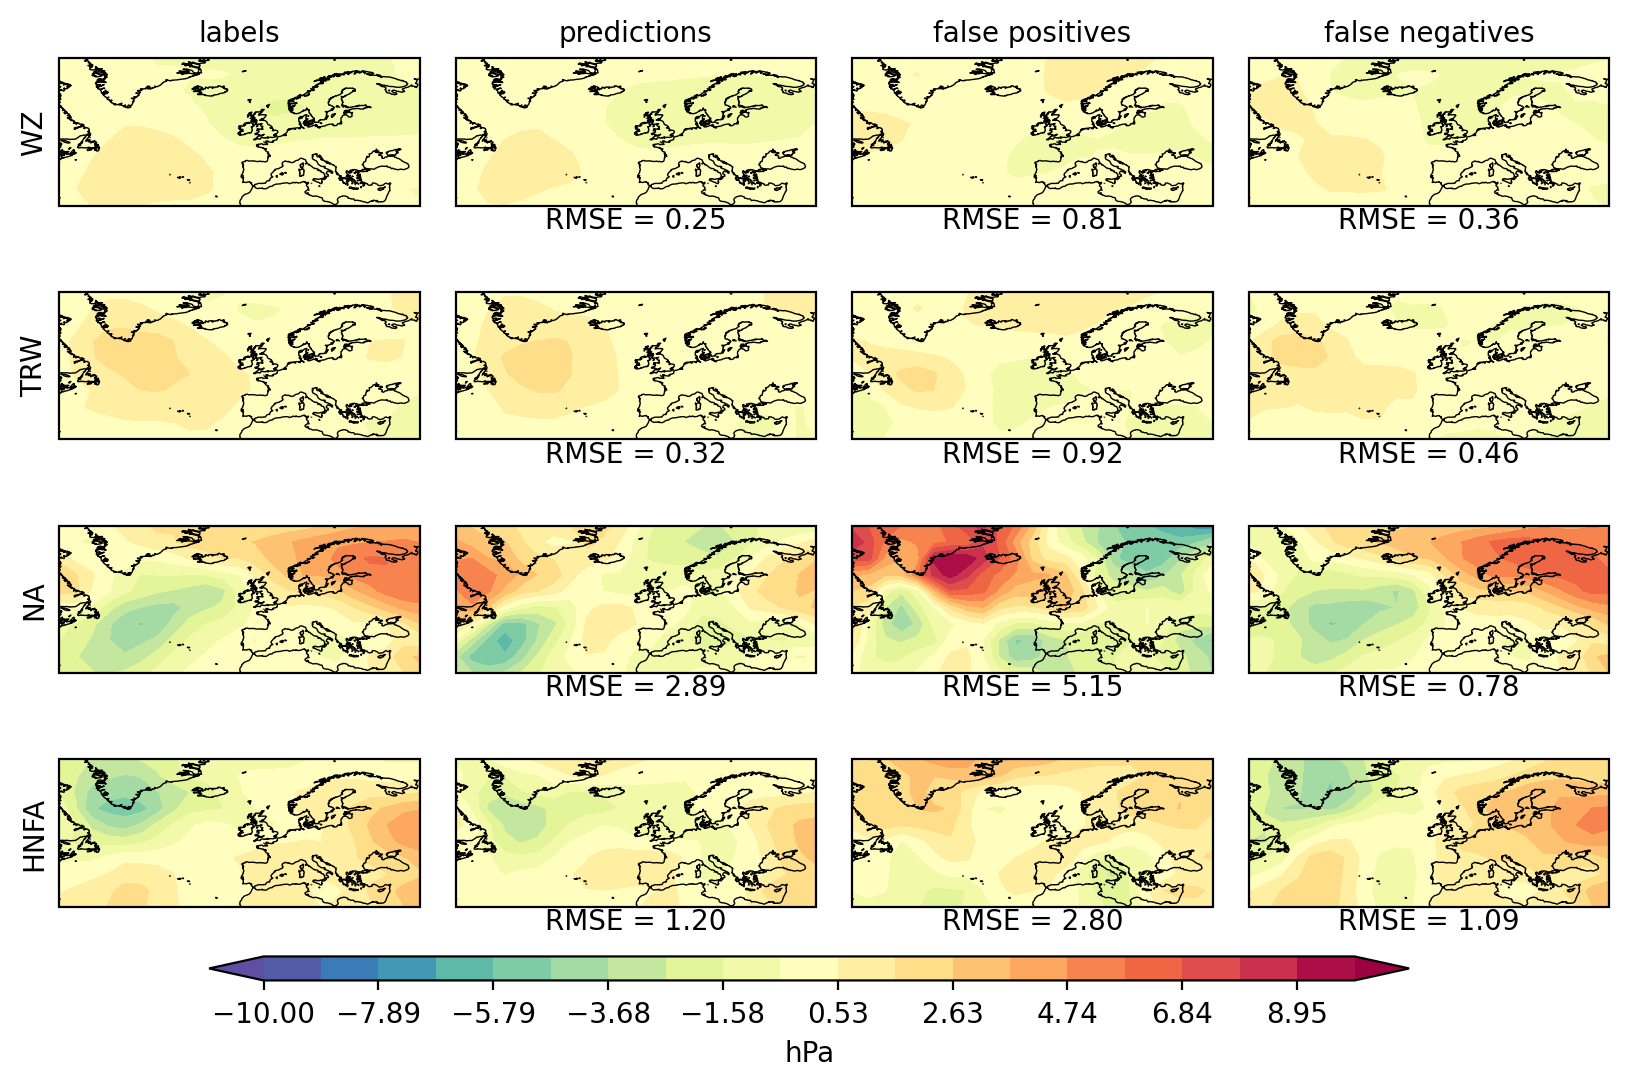

In [29]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define selected classes (min/max RMSE, as in the paper)
selected_classes = ["WZ", "TRW", "NA", "HNFA"]

rmse_data = {
    "sig_pred_slp": df_rmse_cv["RMSE_pred_slp"],
    "sig_fp_slp": df_rmse_cv["RMSE_fp_slp"],
    "sig_fn_slp": df_rmse_cv["RMSE_fn_slp"]
}

slp_cmap = sns.color_palette("Spectral_r", as_cmap=True)

slp_ds = xr.open_dataset(os.path.join(pro_data_path, "era5_slp.nc"))

class_idx = list(map(lbl_2_idx.get, selected_classes))

# Define layout
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.05, wspace=0.1)

# Row Labels
row_labels = ["labels", "predictions", "false positives", "false negatives"]
row_keys = ["sig_true_slp", "sig_pred_slp", "sig_fp_slp", "sig_fn_slp"]

for row, ct in enumerate(class_idx):
    for col, category in enumerate(row_keys):
        ax = axes[row, col]
        _= ax.set_title(row_labels[col] if row == 0 else "", fontsize=10)
        _= ax.set_ylabel(selected_classes[row] if col == 0 else "", fontsize=10)
        
        # Plot SLP data
        im = ax.contourf(
            slp_ds["lon"], slp_ds["lat"], sig_dict_cv_norm[category][ct], 
            levels=np.linspace(-10, 10, 20), cmap=slp_cmap, extend="both"
        )
        _= ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        _= ax.set_xticks([])
        _= ax.set_yticks([])
        
        # Add RMSE annotation
        if category != "sig_true_slp":
            rmse_value = rmse_data[category].loc[idx_2_lbl[ct]]
            _= ax.text(
                0.5, -0.1, f"RMSE = {rmse_value:.2f}", 
                ha="center", va="center", transform=ax.transAxes, fontsize=10
            )

# Colorbar
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
_= cbar.set_label("hPa")
plt.savefig(os.path.join(plot_path, "slp_signature_plots.png"), dpi=300, bbox_inches="tight")
plt.show()

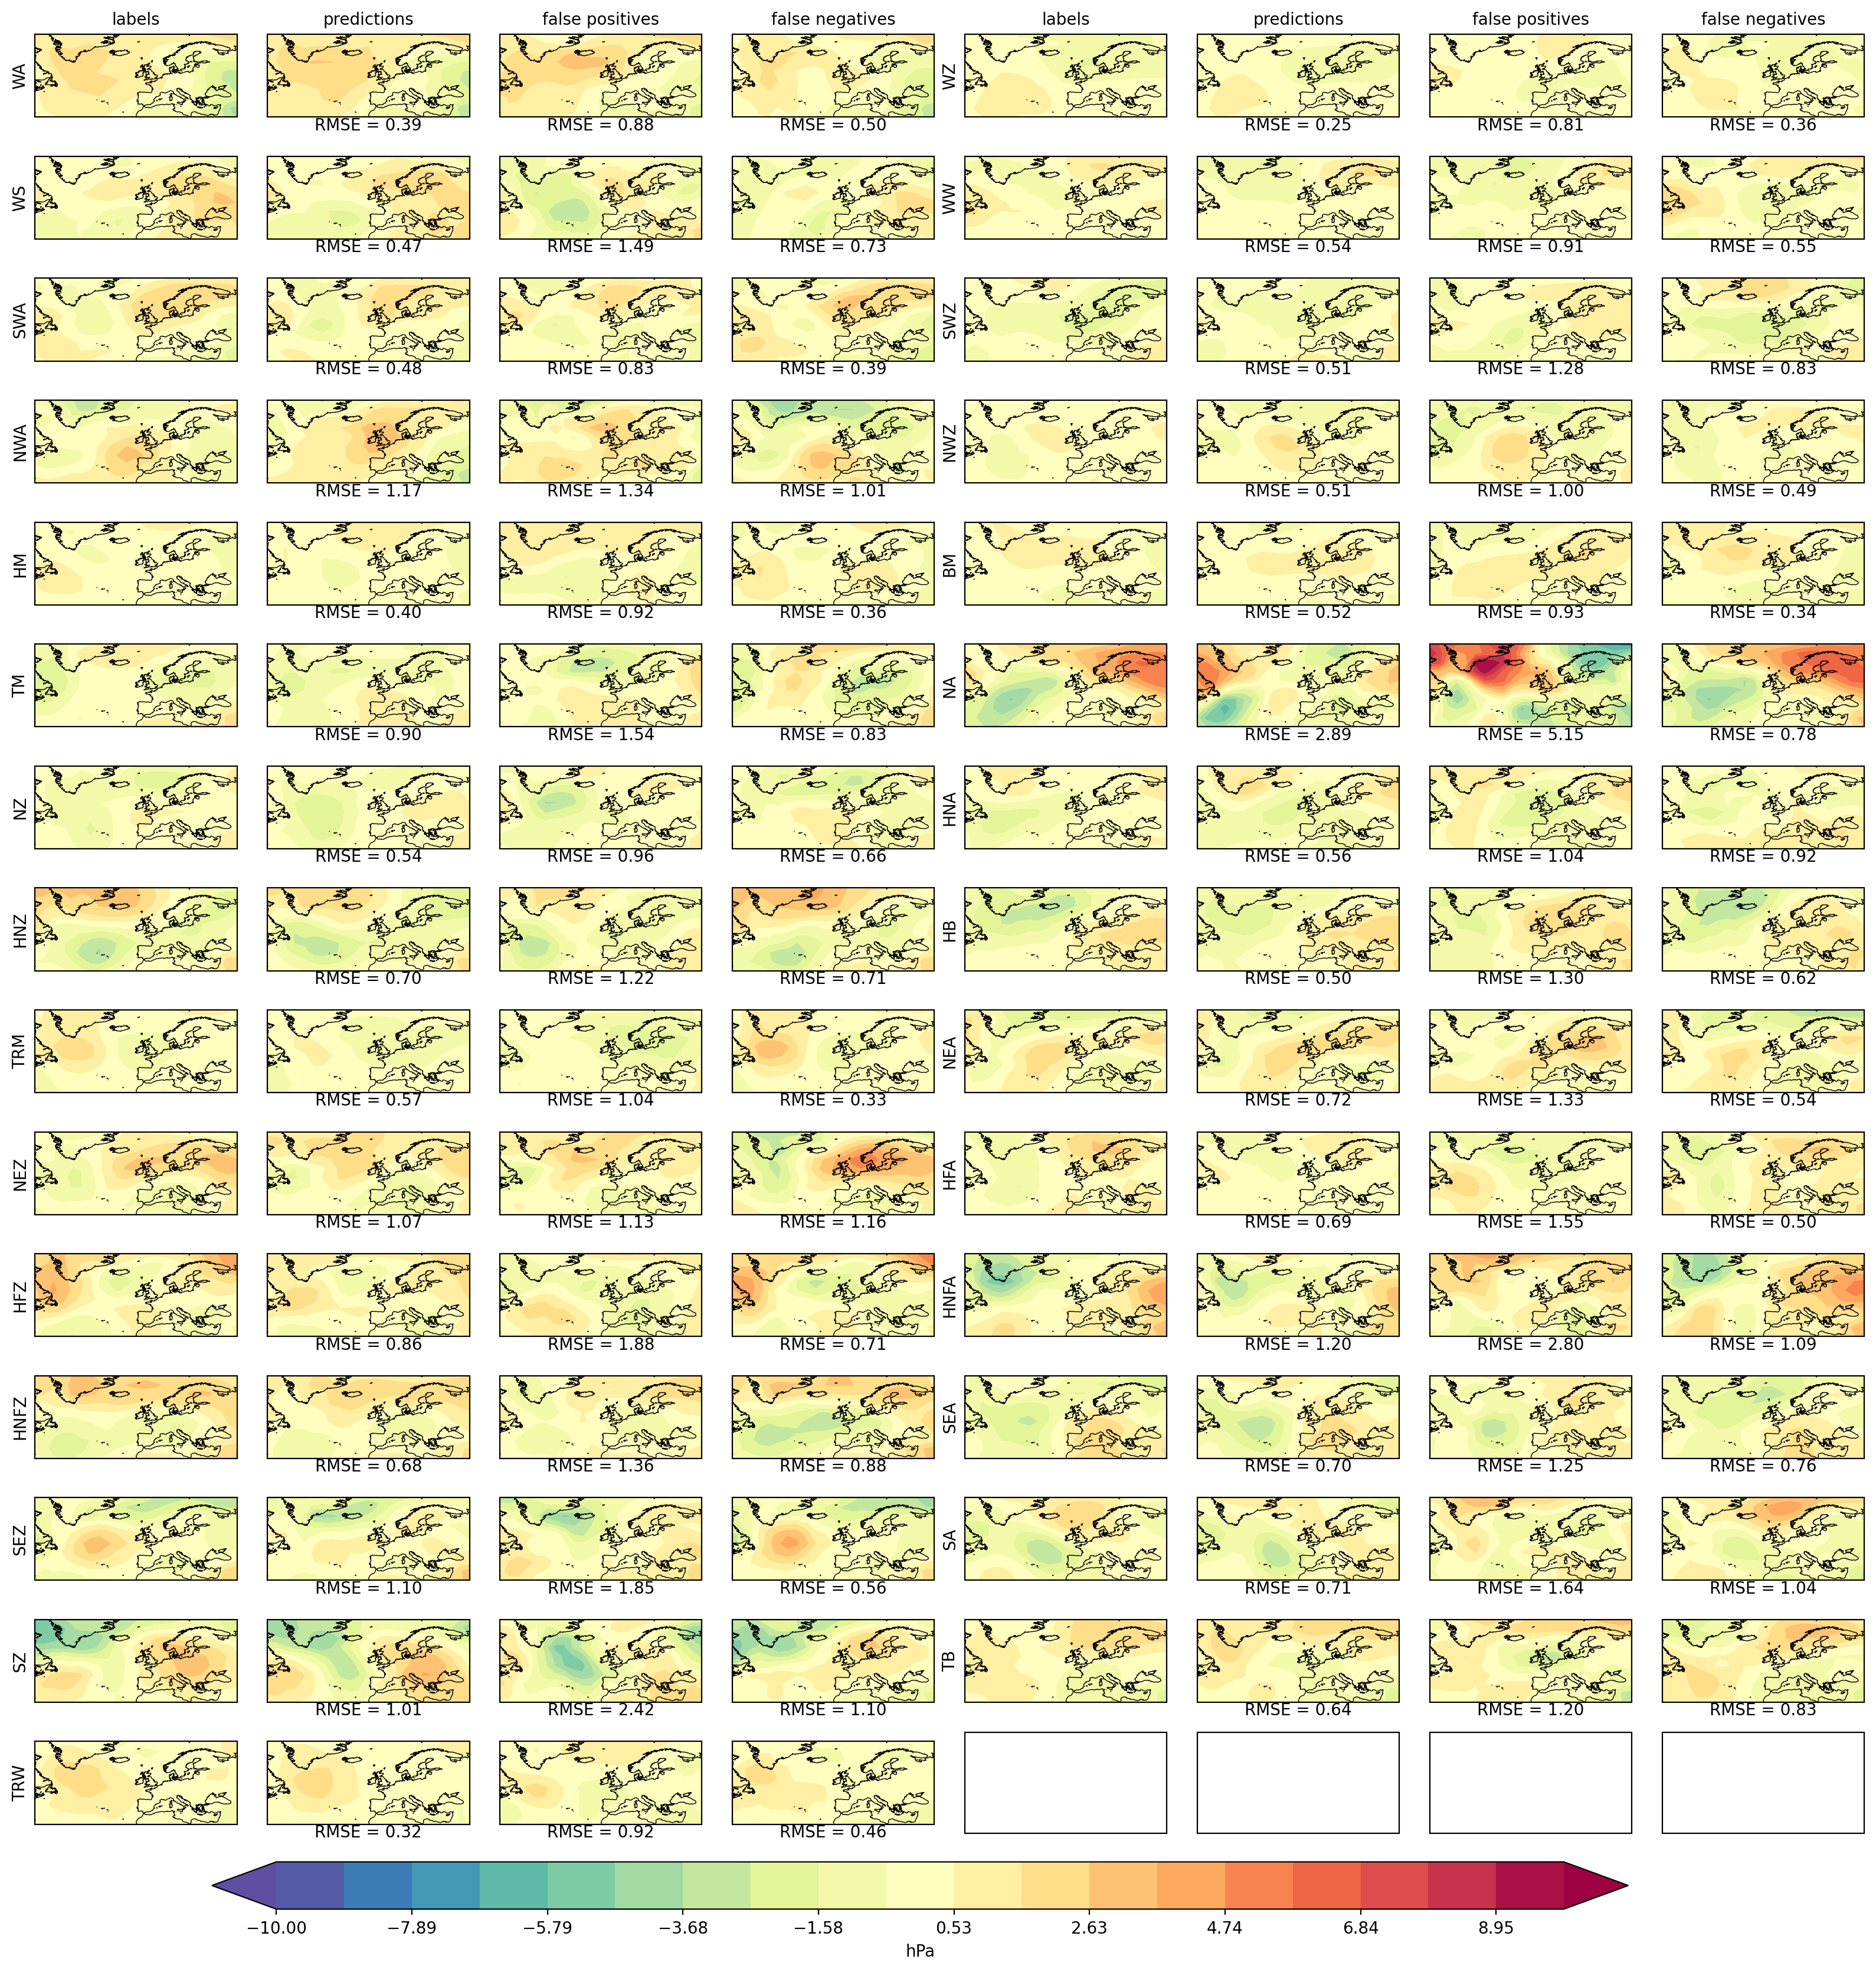

In [57]:
label_order = [
        "WA", "WZ", "WS", "WW", "SWA", "SWZ", "NWA", "NWZ", "HM", "BM",
        "TM", "NA", "NZ", "HNA", "HNZ", "HB", "TRM", "NEA", "NEZ", "HFA",
        "HFZ", "HNFA", "HNFZ", "SEA", "SEZ", "SA", "SZ", "TB", "TRW"
    ]

rmse_data = {
    "sig_pred_slp": df_rmse_cv["RMSE_pred_slp"],
    "sig_fp_slp": df_rmse_cv["RMSE_fp_slp"],
    "sig_fn_slp": df_rmse_cv["RMSE_fn_slp"]
}

slp_cmap = sns.color_palette("Spectral_r", as_cmap=True)

slp_ds = xr.open_dataset(os.path.join(pro_data_path, "era5_slp.nc"))

class_idx = list(map(lbl_2_idx.get, label_order))

# Define layout
fig, axes = plt.subplots(nrows=15, ncols=8, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.1, wspace=0.15)

# Row Labels
row_labels = ["labels", "predictions", "false positives", "false negatives"]
row_keys = ["sig_true_slp", "sig_pred_slp", "sig_fp_slp", "sig_fn_slp"]

for r, ct in enumerate(class_idx):
    row = r // 2
    colsum = r % 2
    for c, category in enumerate(row_keys):
        col = c + 4 * colsum
        ax = axes[row, col]
        _= ax.set_title(row_labels[c] if row == 0 else "", fontsize=10)
        _= ax.set_ylabel(label_order[r] if col in [0, 4] else "", fontsize=10)
        
        # Plot SLP data
        im = ax.contourf(
            slp_ds["lon"], slp_ds["lat"], sig_dict_cv_norm[category][ct], 
            levels=np.linspace(-10, 10, 20), cmap=slp_cmap, extend="both"
        )
        _= ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        _= ax.set_xticks([])
        _= ax.set_yticks([])
        
        # Add RMSE annotation
        if category != "sig_true_slp":
            rmse_value = rmse_data[category].loc[idx_2_lbl[ct]]
            _= ax.text(
                0.5, -0.1, f"RMSE = {rmse_value:.2f}", 
                ha="center", va="center", transform=ax.transAxes, fontsize=10
            )

# Colorbar
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
_= cbar.set_label("hPa")
plt.savefig(os.path.join(plot_path, "slp_signature_plots_all.png"), dpi=300, bbox_inches="tight")
plt.show()

In [37]:
def plot_class_occurrences(y_true, y_pred, lbl_2_idx, savepath, years=31):
    """
    Plot bar chart comparing occurrence frequency of each class (labels vs predictions).

    Parameters:
    - y_true: np.array, true circulation type labels
    - y_pred: np.array, predicted circulation type labels
    - lbl_2_idx: dict, mapping from label names to indices
    - years: int, number of years in the dataset for normalizing days per year
    """

    # Define the correct class order
    label_order = [
        "WA", "WZ", "WS", "WW", "SWA", "SWZ", "NWA", "NWZ", "HM", "BM",
        "TM", "NA", "NZ", "HNA", "HNZ", "HB", "TRM", "NEA", "NEZ", "HFA",
        "HFZ", "HNFA", "HNFZ", "SEA", "SEZ", "SA", "SZ", "TB", "TRW"
    ]

    class_idx = list(map(lbl_2_idx.get, label_order))

    unique_labels, counts_true = np.unique(y_true, return_counts=True)
    unique_preds, counts_pred = np.unique(y_pred, return_counts=True)

    count_dict_true = dict(zip(unique_labels, counts_true / years))  # Normalize per year
    count_dict_pred = dict(zip(unique_preds, counts_pred / years))

    counts_true = [count_dict_true.get(i, 0) for i in class_idx]
    counts_pred = [count_dict_pred.get(i, 0) for i in class_idx]

    df = pd.DataFrame({"Class": label_order, "Labels": counts_true, "Network": counts_pred})

    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.4
    x = np.arange(len(label_order))

    bars1 = ax.bar(x - width/2, df["Labels"], width=width, color="blue", label="Labels", alpha=0.8)
    bars2 = ax.bar(x + width/2, df["Network"], width=width, color="goldenrod", label="Network", alpha=0.8)

    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.0f}",
                ha='center', va='bottom', fontsize=9, color="blue", fontweight="bold")

    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.0f}",
                ha='center', va='bottom', fontsize=9, color="goldenrod", fontweight="bold")

    ax.set_xticks(x)
    ax.set_xticklabels(label_order, rotation=90)
    ax.set_ylabel("Number of days per year")
    ax.set_title("1950-1980")
    ax.legend()

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()

In [11]:
X_tr = np.load(os.path.join(train_path, "X_train_seasonal.npy"))
X_tr.shape
boxplot_each, all_preds, all_probs = predict(X_tr, model_path, each_ensemble=True) # for f1 boxplots later
smooth_all_preds = transition_smoothing(all_preds, all_probs)
labels = np.load(os.path.join(pro_data_path, "clean_gwl_1950_1980_lbl.npy"))
all_true = list(map(lbl_2_idx.get, labels))

(11183, 2, 10, 23)

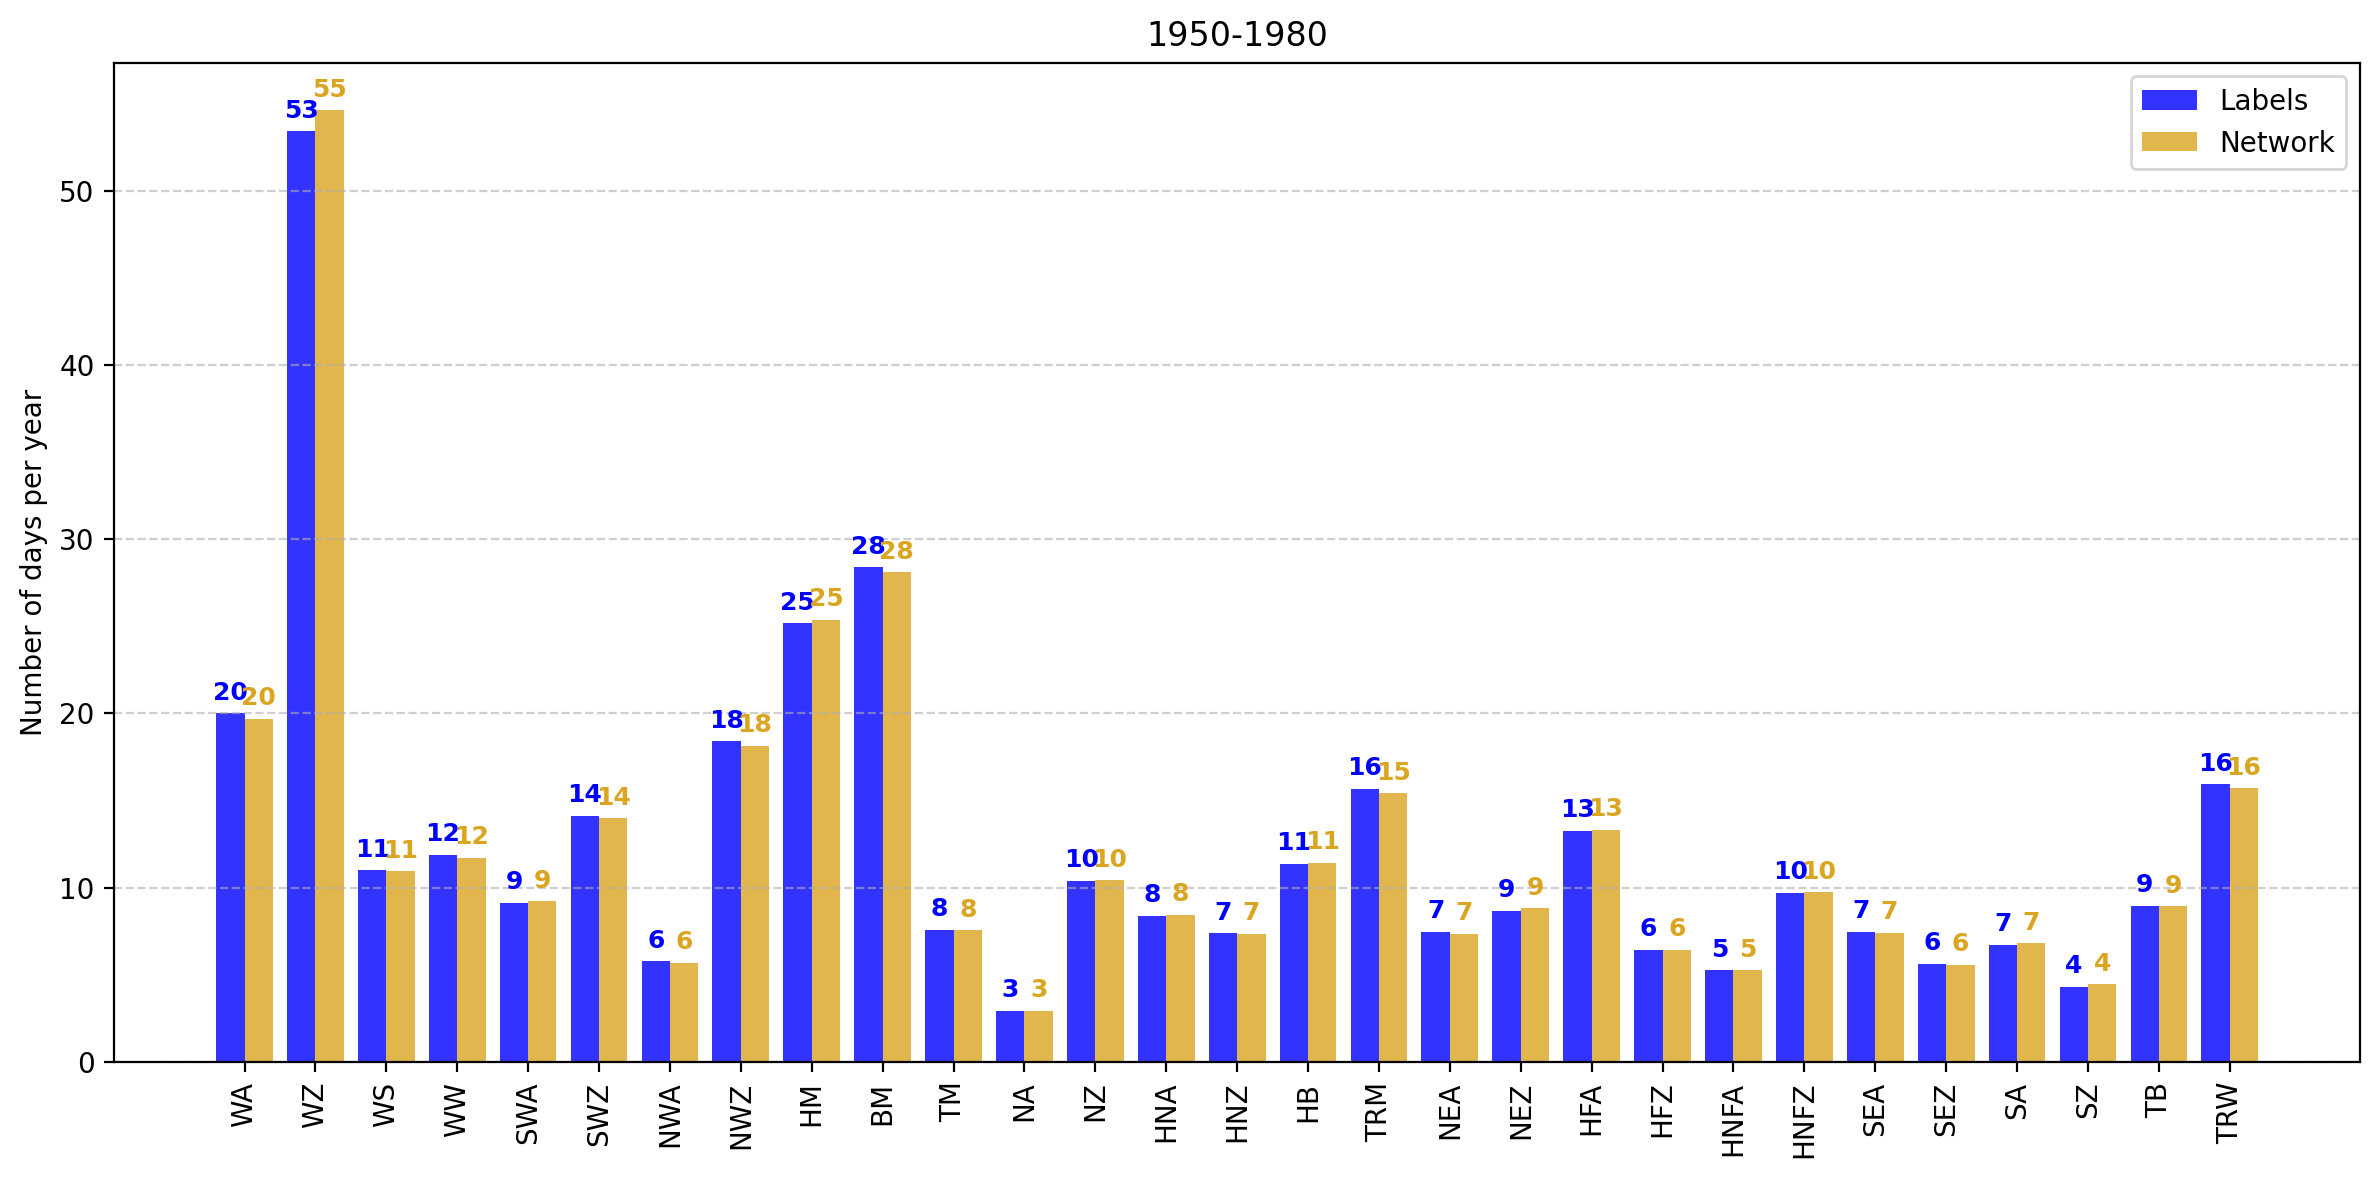

In [38]:
fig_path = os.path.join(plot_path,'daycount.png')
plot_class_occurrences(all_true, smooth_all_preds, lbl_2_idx, fig_path)

## CanESM2 - past & future compare

In [11]:
##### Test on CANESM data
pro_test_path = os.path.join(pro_data_path, 'CanESM2')
historical = ['r1', 'r3', 'r5']
subsets = ['r2', 'r4', 'r6', 'r8']

slp_past = {}
z500_past = {}
slp_future = {}
z500_future = {}

X_past = {}
X_future = {}
for his in historical:
    for sub in subsets:
        key = f"{his}_{sub}"
        slp_1 = xr.open_dataset(os.path.join(pro_test_path, f'slp_{his}_{sub}_past.nc'))
        slp_past[key] = slp_1
        z500_1 = xr.open_dataset(os.path.join(pro_test_path, f'z500_{his}_{sub}_past.nc'))
        z500_past[key] = z500_1
        slp_2 = xr.open_dataset(os.path.join(pro_test_path, f'slp_{his}_{sub}_future.nc'))
        slp_future[key] = slp_2
        z500_2 = xr.open_dataset(os.path.join(pro_test_path, f'z500_{his}_{sub}_future.nc'))
        z500_future[key] = z500_2
        past_data = np.stack([slp_1['data'].values, z500_1['data'].values], axis=1)
        future_data = np.stack([slp_2['data'].values, z500_2['data'].values], axis=1)
        X_past[key] = past_data
        X_future[key] = future_data
        print(key, past_data.shape, future_data.shape)

r1_r2 (10950, 2, 10, 23) (10950, 2, 10, 23)
r1_r4 (10950, 2, 10, 23) (10950, 2, 10, 23)
r1_r6 (10950, 2, 10, 23) (10950, 2, 10, 23)
r1_r8 (10950, 2, 10, 23) (10950, 2, 10, 23)
r3_r2 (10950, 2, 10, 23) (10950, 2, 10, 23)
r3_r4 (10950, 2, 10, 23) (10950, 2, 10, 23)
r3_r6 (10950, 2, 10, 23) (10950, 2, 10, 23)
r3_r8 (10950, 2, 10, 23) (10950, 2, 10, 23)
r5_r2 (10950, 2, 10, 23) (10950, 2, 10, 23)
r5_r4 (10950, 2, 10, 23) (10950, 2, 10, 23)
r5_r6 (10950, 2, 10, 23) (10950, 2, 10, 23)
r5_r8 (10950, 2, 10, 23) (10950, 2, 10, 23)


In [15]:
def normalize_with_moments(X, mean_tr, var_tr, epsilon=1e-8):
    """
    Apply Z-score normalization to new data.

    :param X: NumPy array of shape (time, 2, lat, lon)
    :param mean_X: Mean of training set (2, lat, lon)
    :param var_X: Variance of training set (2, lat, lon)
    :param epsilon: Small value to prevent division by zero
    :return: Standardized X
    """
    return (X - mean_tr) / np.sqrt(var_tr + epsilon)

In [16]:
m = np.load(os.path.join(train_path, "mean_tr.npy"))
v = np.load(os.path.join(train_path, "var_tr.npy"))


for his in historical:
    for sub in subsets:
        key = f"{his}_{sub}"
        X_past_norm = normalize_with_moments(X_past[key], m, v)
        X_past[key] = X_past_norm
        X_future_norm = normalize_with_moments(X_future[key], m, v)
        X_future[key] = X_future_norm

In [17]:
def center_seasons(X, valid_month, mean_train_seasonal):
    """
    Perform seasonal adjustment by subtracting the seasonal mean.

    :param X: Data array of shape (time, 2, lat, lon)
    :param valid_month: List of months of timestamps corresponding to each data sample
    :param mean_train_seasonal: Array of seasonal means (12, 2, lat, lon)
    :return: Seasonally adjusted data
    """
    X_adjusted = np.zeros_like(X, dtype=X.dtype)

    season_dict = {
        "Spring": [3, 4, 5],   # Mar, Apr, May
        "Summer": [6, 7, 8],   # Jun, Jul, Aug
        "Fall":   [9, 10, 11],  # Sep, Oct, Nov
        "Winter": [12, 1, 2]  # Dec, Jan, Feb
    }

    for i, months in enumerate(season_dict.values()):
        season_indices = np.isin(valid_month, months)
        X_adjusted[season_indices,:,:,:] = X[season_indices,:,:,:] - mean_train_seasonal[i]

    return X_adjusted

In [18]:
# Seasonal adjustment

valid_month_past = slp_past['r1_r2']["time"].dt.month.values
valid_month_future = slp_future['r1_r2']["time"].dt.month.values

season_dict = {
        "Spring": [3, 4, 5],   # Mar, Apr, May
        "Summer": [6, 7, 8],   # Jun, Jul, Aug
        "Fall":   [9, 10, 11],  # Sep, Oct, Nov
        "Winter": [12, 1, 2]  # Dec, Jan, Feb
    }

mean_train_seasonal = np.load(os.path.join(train_path, "mean_train_seasonal.npy"))


for his in historical:
    for sub in subsets:
        key = f"{his}_{sub}"
        X_past_seasonal = center_seasons(X_past[key], valid_month_past, mean_train_seasonal)
        X_past[key] = X_past_seasonal
        X_future_seasonal = center_seasons(X_future[key], valid_month_future, mean_train_seasonal)
        X_future[key] = X_future_seasonal
        np.save(os.path.join(pro_test_path, f"X_{key}_past_seasonal.npy"), X_past_seasonal)
        np.save(os.path.join(pro_test_path, f"X_{key}_future_seasonal.npy"), X_future_seasonal)

In [28]:
pred_past_dict = {}
pred_future_dict = {}
smooth_pred_past_dict = {}
smooth_pred_future_dict = {}
for his in historical:
    for sub in subsets:
        key = f"{his}_{sub}"
        pred_past, softmax_past = predict(X_past[key], model_path)
        pred_past_dict[key] = pred_past
        pred_future, softmax_future = predict(X_future[key], model_path)
        pred_future_dict[key] = pred_future

        smooth_pred_past = transition_smoothing(pred_past, softmax_past)
        smooth_pred_past_dict[key] = smooth_pred_past
        smooth_pred_future = transition_smoothing(pred_future, softmax_future)
        smooth_pred_future_dict[key] = smooth_pred_future

        diffs = pred_past != smooth_pred_past
        num_diff = np.sum(diffs)
        percent = num_diff / len(pred_past) * 100
        print(key)
        print(f"Past smoothed labels: {num_diff} / {len(pred_past)} ({percent:.2f}%)")
        print(f'Past smoothed indices: {np.where(diffs)[0].tolist()}')

        diffs = pred_future != smooth_pred_future
        num_diff = np.sum(diffs)
        percent = num_diff / len(pred_future) * 100
        print(f"Future smoothed labels: {num_diff} / {len(pred_future)} ({percent:.2f}%)")
        print(f'Future smoothed indices: {np.where(diffs)[0].tolist()}')
        print('\n')

np.save(os.path.join(pro_test_path, 'pred_past.npy'), pred_past_dict, allow_pickle=True)
np.save(os.path.join(pro_test_path, 'pred_future.npy'), pred_future_dict, allow_pickle=True)
np.save(os.path.join(pro_test_path, 'smooth_pred_past.npy'), smooth_pred_past_dict, allow_pickle=True)
np.save(os.path.join(pro_test_path, 'smooth_pred_future.npy'), smooth_pred_future_dict, allow_pickle=True)

r1_r2
Past smoothed labels: 3254 / 10950 (29.72%)
Past smoothed indices: [2, 5, 70, 71, 72, 73, 96, 100, 101, 102, 105, 109, 110, 112, 115, 118, 119, 124, 125, 126, 127, 128, 135, 139, 140, 144, 145, 146, 147, 148, 151, 162, 163, 168, 174, 175, 176, 180, 186, 188, 191, 193, 194, 195, 196, 197, 203, 204, 205, 206, 211, 212, 213, 219, 220, 221, 228, 229, 236, 237, 238, 239, 240, 241, 249, 250, 262, 265, 268, 269, 272, 273, 274, 275, 279, 280, 284, 291, 292, 293, 294, 295, 296, 297, 313, 315, 316, 317, 318, 319, 338, 339, 351, 355, 356, 357, 358, 359, 360, 361, 362, 369, 377, 378, 379, 380, 381, 382, 383, 384, 389, 390, 395, 399, 400, 409, 410, 411, 422, 423, 429, 430, 438, 440, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 459, 460, 461, 463, 482, 484, 500, 508, 509, 510, 511, 512, 513, 516, 521, 522, 523, 529, 530, 531, 533, 540, 541, 542, 543, 544, 545, 546, 547, 548, 551, 561, 562, 563, 570, 576, 577, 581, 582, 589, 593, 595, 599, 600, 612, 613, 622, 642, 643, 644, 645, 

In [12]:

pred_past_dict = np.load(os.path.join(pro_test_path, 'pred_past.npy'), allow_pickle=True)
pred_past_dict = dict(pred_past_dict.tolist())
pred_future_dict = np.load(os.path.join(pro_test_path, 'pred_future.npy'), allow_pickle=True)
pred_future_dict = dict(pred_future_dict.tolist())
smooth_pred_past_dict = np.load(os.path.join(pro_test_path, 'smooth_pred_past.npy'), allow_pickle=True)
smooth_pred_past_dict = dict(smooth_pred_past_dict.tolist())
smooth_pred_future_dict = np.load(os.path.join(pro_test_path, 'smooth_pred_future.npy'), allow_pickle=True)
smooth_pred_future_dict = dict(smooth_pred_future_dict.tolist())


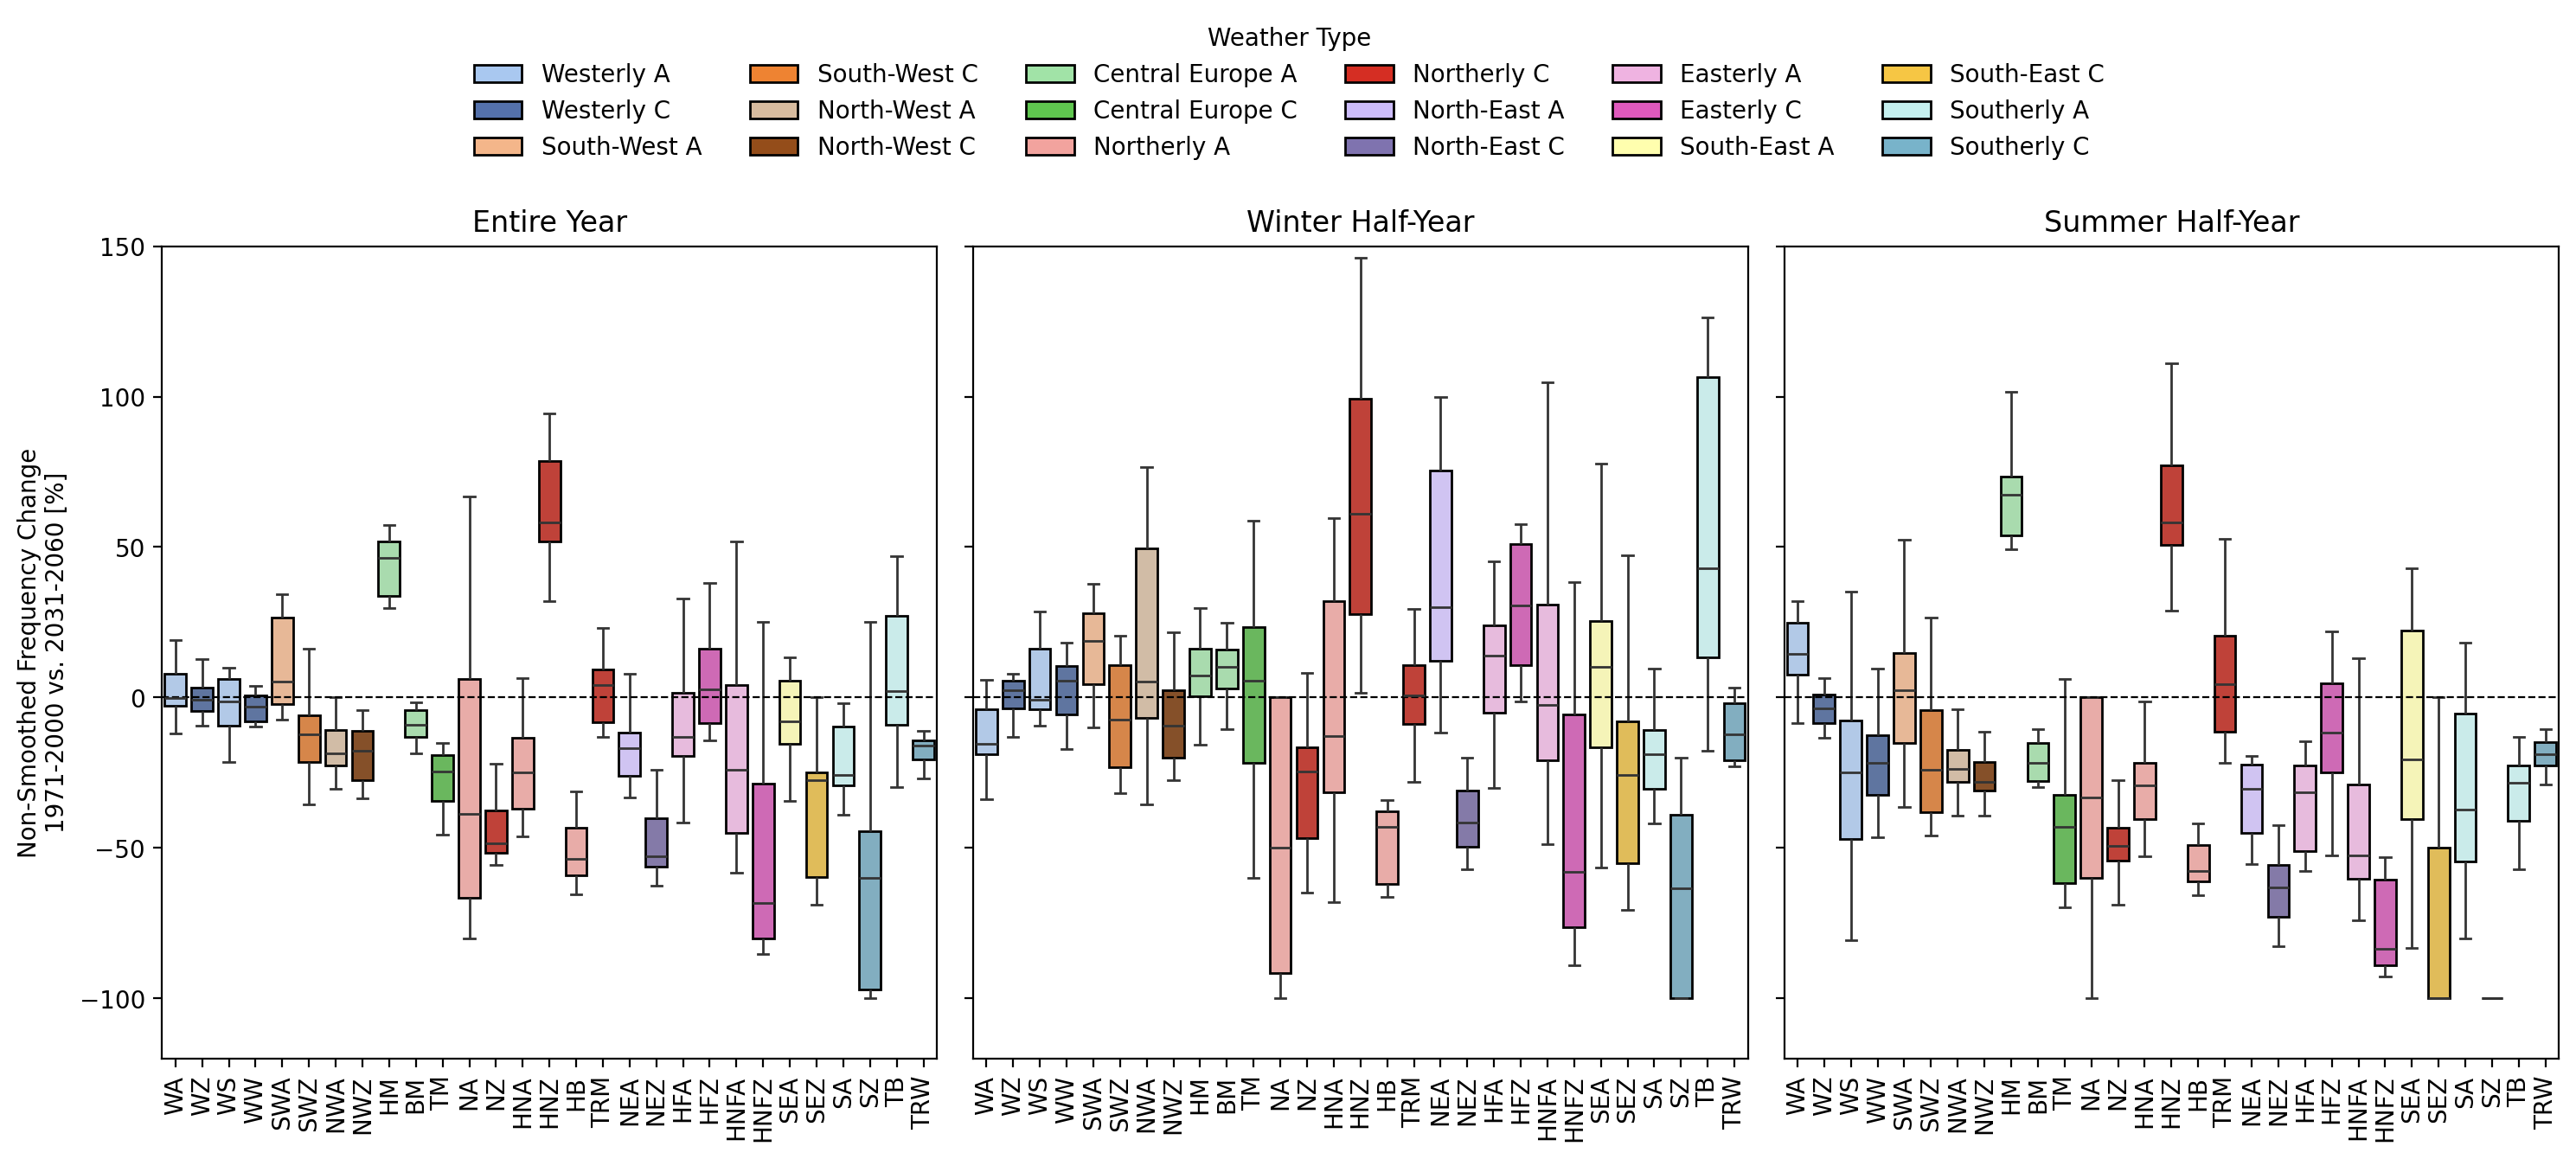

In [14]:
# Define seasons
winter_months = [10, 11, 12, 1, 2, 3]
summer_months = [4, 5, 6, 7, 8, 9]

# Get seasonal indices
valid_month_past = slp_past['r1_r2']["time"].dt.month.values
valid_month_future = slp_future['r1_r2']["time"].dt.month.values
winter_past_idx = np.isin(valid_month_past, winter_months)
summer_past_idx = np.isin(valid_month_past, summer_months)

winter_future_idx = np.isin(valid_month_future, winter_months)
summer_future_idx = np.isin(valid_month_future, summer_months)

# Compute yearly frequency for entire year, winter, and summer
years = 30  # 1971-2000, 2031-2060
num_classes = 29

# Entire Year
freq_change_list = []
freq_change_winter_list = []
freq_change_summer_list = []
for his in historical:
    for sub in subsets:
        key = f"{his}_{sub}"
        pred_past = pred_past_dict[key]
        freq_past = np.array([np.sum(pred_past == i) / years for i in range(num_classes)])
        pred_future = pred_future_dict[key]
        freq_future = np.array([np.sum(pred_future == i) / years for i in range(num_classes)])
        freq_change_solo = 100 * (freq_future - freq_past) / freq_past
        freq_change_list.append(freq_change_solo.tolist())

        # Winter
        freq_past_winter = np.array([np.sum(pred_past[winter_past_idx] == i) / years for i in range(num_classes)])
        freq_future_winter = np.array([np.sum(pred_future[winter_future_idx] == i) / years for i in range(num_classes)])
        freq_change_winter_solo = 100 * (freq_future_winter - freq_past_winter) / freq_past_winter
        freq_change_winter_list.append(freq_change_winter_solo.tolist())

        # Summer
        freq_past_summer = np.array([np.sum(pred_past[summer_past_idx] == i) / years for i in range(num_classes)])
        freq_future_summer = np.array([np.sum(pred_future[summer_future_idx] == i) / years for i in range(num_classes)])
        freq_change_summer_solo = 100 * (freq_future_summer - freq_past_summer) / freq_past_summer
        freq_change_summer_list.append(freq_change_summer_solo.tolist())

freq_change = np.array(freq_change_list)
freq_change_winter = np.array(freq_change_winter_list)
freq_change_summer = np.array(freq_change_summer_list)

# Ensure class order is consistent
label_order = ["WA", "WZ", "WS", "WW", "SWA", "SWZ", "NWA", "NWZ", "HM", "BM",
               "TM", "NA", "NZ", "HNA", "HNZ", "HB", "TRM", "NEA", "NEZ", "HFA",
               "HFZ", "HNFA", "HNFZ", "SEA", "SEZ", "SA", "SZ", "TB", "TRW"]

class_colors = {
    "Westerly A": "#a9c8f0", "Westerly C": "#5471ab", 
    "South-West A": "#f4b68a", "South-West C": "#ee8332",
    "North-West A": "#d8bc9f", "North-West C": "#944d1a", 
    "Central Europe A": "#a1e3a7", "Central Europe C": "#5fc64f", 
    "Northerly A": "#f2a39e", "Northerly C": "#d52e23",
    "North-East A": "#ccbcfa", "North-East C": "#7f73af", 
    "Easterly A": "#efb3e1", "Easterly C": "#df59bd",
    "South-East A": "#fffeae", "South-East C": "#f6c644", 
    "Southerly A": "#c5f0ef", "Southerly C": "#78b3ca"
}

label_to_type = {
    "WA": "Westerly A", "WZ": "Westerly C", "WS": "Westerly A", "WW": "Westerly C",
    "SWA": "South-West A", "SWZ": "South-West C", 
    "NWA": "North-West A", "NWZ": "North-West C",
    "HM": "Central Europe A", "BM": "Central Europe A", "TM": "Central Europe C",
    "NA": "Northerly A", "NZ": "Northerly C", "HNA": "Northerly A", "HNZ": "Northerly C", "HB": "Northerly A", "TRM": "Northerly C",
    "NEA": "North-East A", "NEZ": "North-East C", 
    "HFA": "Easterly A", "HFZ": "Easterly C",
    "HNFA": "Easterly A", "HNFZ": "Easterly C",
    "SEA": "South-East A", "SEZ": "South-East C",
    "SA": "Southerly A", "SZ": "Southerly C", "TB": "Southerly A", "TRW": "Southerly C"
}

palette = [class_colors[label_to_type[label]] for label in label_order]

# Reorder frequencies
class_str = list(map(idx_2_lbl.get, range(num_classes)))
freq_order = [class_str.index(lbl) for lbl in label_order]

freq_change = freq_change[:, freq_order]
freq_change_winter = freq_change_winter[:, freq_order]
freq_change_summer = freq_change_summer[:, freq_order]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, freq_change_data, title in zip(
    axes,
    [freq_change, freq_change_winter, freq_change_summer],
    ["Entire Year", "Winter Half-Year", "Summer Half-Year"]
):
    _= sns.boxplot(data=freq_change_data, ax=ax, palette=palette, showfliers=False, boxprops=dict(edgecolor="black"))
    _= ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
    _= ax.set_xticks(range(num_classes))
    _= ax.set_xticklabels(label_order, rotation=90)
    _= ax.set_title(title)
    _= ax.set_ylabel("Non-Smoothed Frequency Change\n1971-2000 vs. 2031-2060 [%]")
    _= ax.set_ylim(-120, 150)

from matplotlib.patches import Patch
legend_types = list(class_colors.keys())
legend_patches = [
    Patch(facecolor=class_colors[wt], edgecolor='black', label=wt)
    for wt in legend_types
]
_= fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=6,
    frameon=False, fontsize='medium', title="Weather Type", title_fontsize='medium')

_= plt.tight_layout(rect=[0, 0, 1, 0.95])
_= plt.savefig(os.path.join(plot_path, "non_s_boxplot_freq_change.png"), dpi=300, bbox_inches="tight")
_= plt.show()

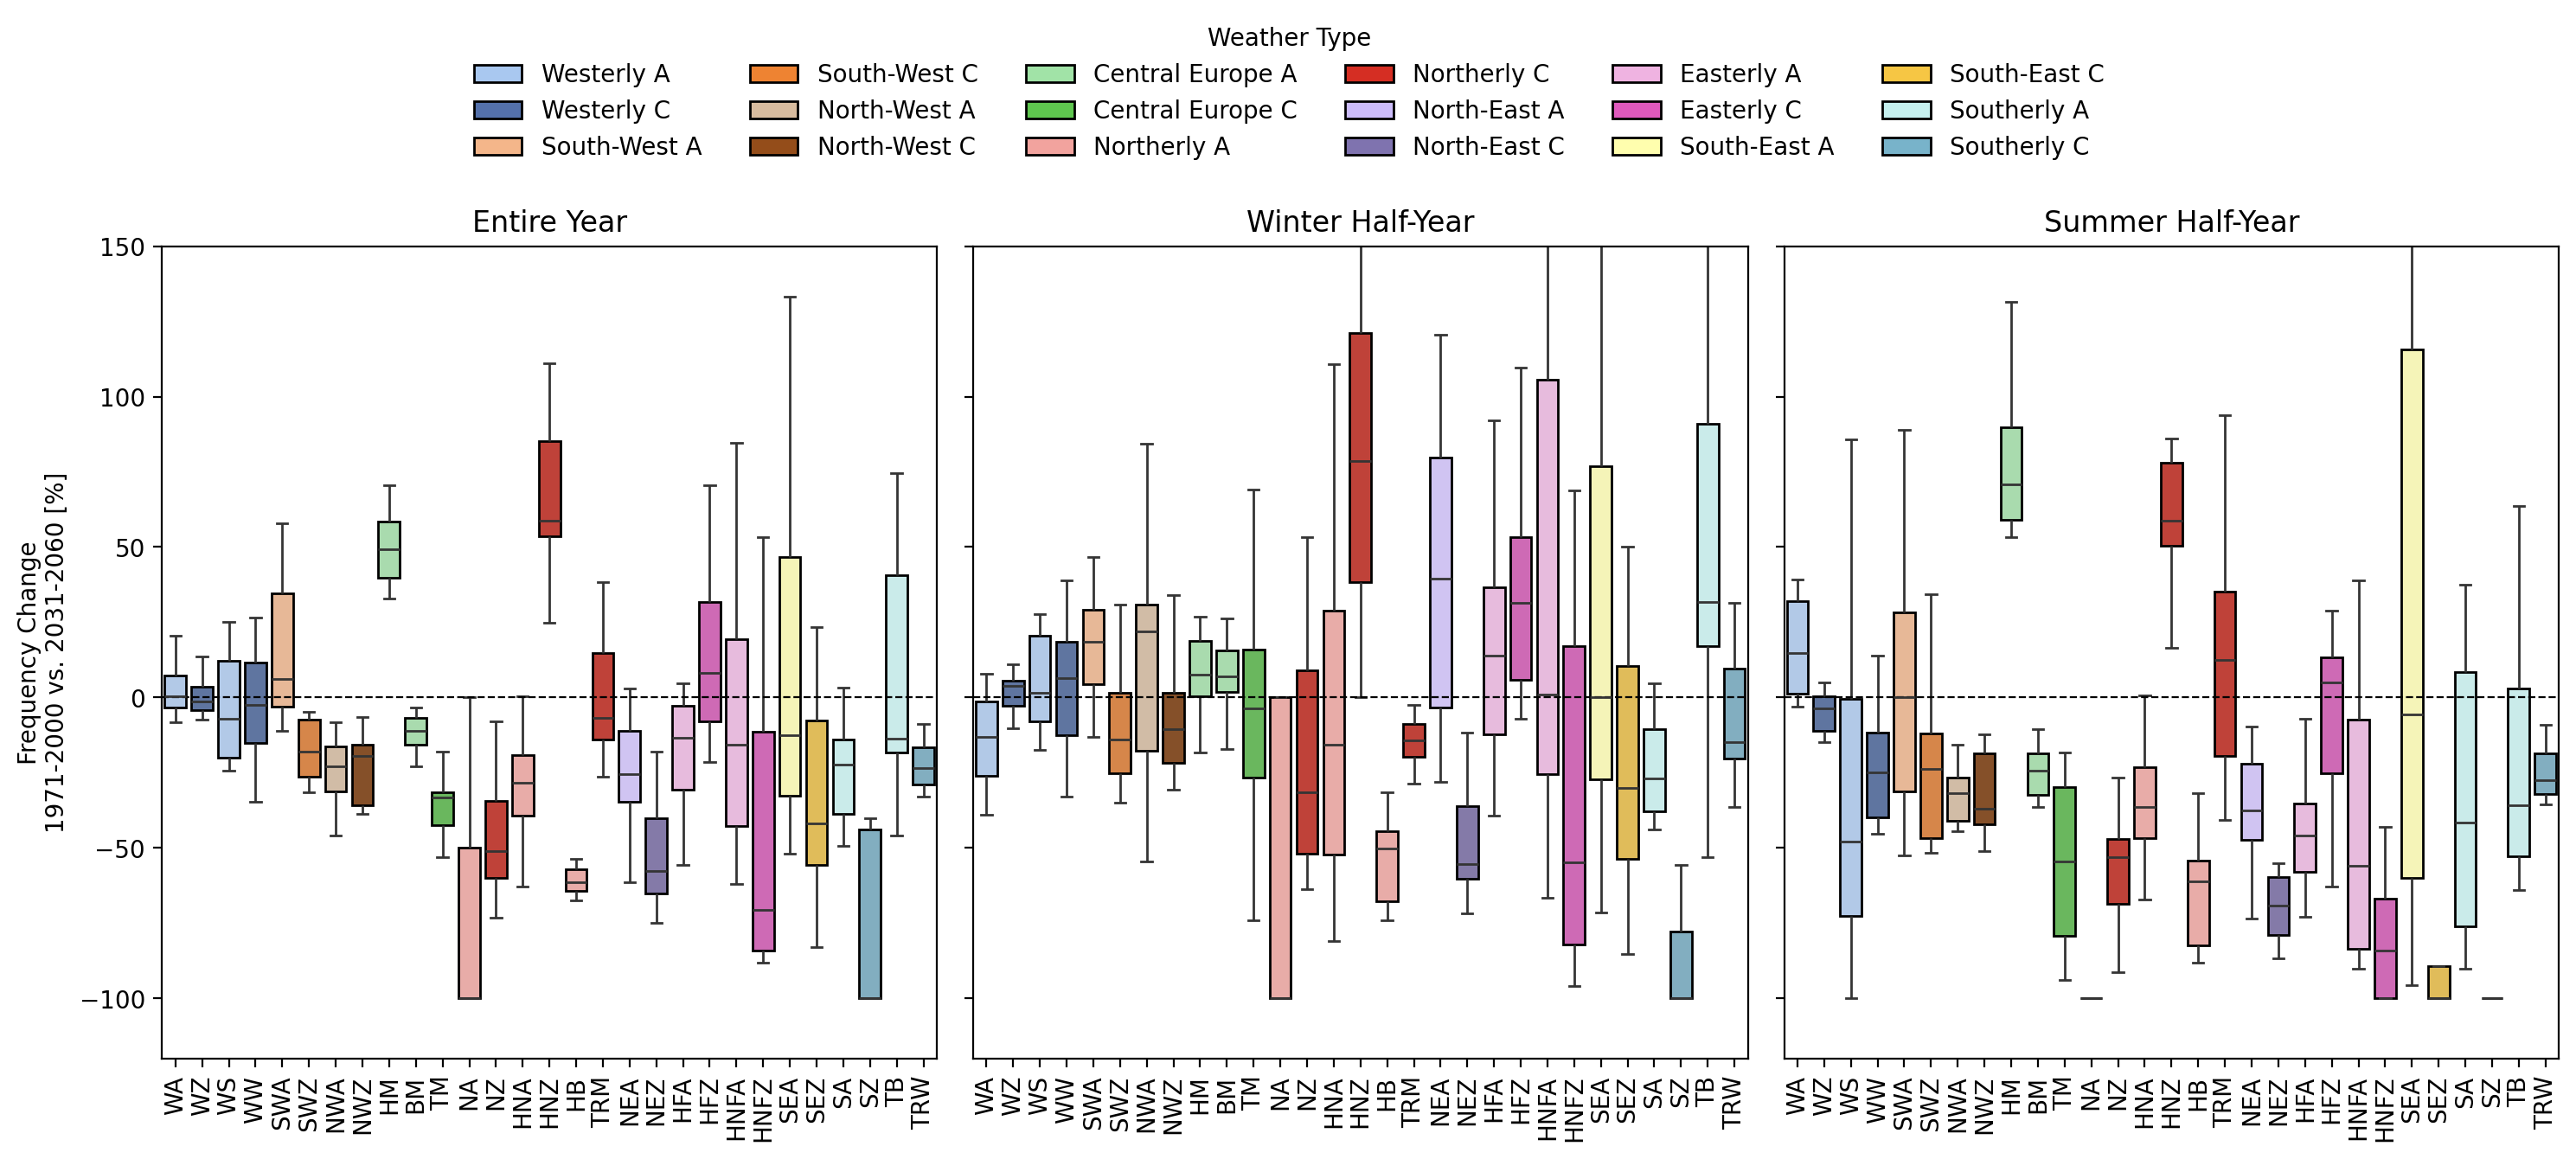

In [8]:
# Define seasons
winter_months = [10, 11, 12, 1, 2, 3]
summer_months = [4, 5, 6, 7, 8, 9]

# Get seasonal indices
winter_past_idx = np.isin(valid_month_past, winter_months)
summer_past_idx = np.isin(valid_month_past, summer_months)

winter_future_idx = np.isin(valid_month_future, winter_months)
summer_future_idx = np.isin(valid_month_future, summer_months)

# Compute yearly frequency for entire year, winter, and summer
years = 30  # 1971-2000, 2031-2060
num_classes = 29

# Entire Year
freq_change_list_smooth = []
freq_change_winter_list_smooth = []
freq_change_summer_list_smooth = []
for his in historical:
    for sub in subsets:
        key = f"{his}_{sub}"
        pred_past = smooth_pred_past_dict[key]
        freq_past = np.array([np.sum(pred_past == i) / years for i in range(num_classes)])
        pred_future = smooth_pred_future_dict[key]
        freq_future = np.array([np.sum(pred_future == i) / years for i in range(num_classes)])
        freq_change_solo = 100 * (freq_future - freq_past) / freq_past
        freq_change_list_smooth.append(freq_change_solo.tolist())

        # Winter
        freq_past_winter = np.array([np.sum(pred_past[winter_past_idx] == i) / years for i in range(num_classes)])
        freq_future_winter = np.array([np.sum(pred_future[winter_future_idx] == i) / years for i in range(num_classes)])
        freq_change_winter_solo = 100 * (freq_future_winter - freq_past_winter) / freq_past_winter
        freq_change_winter_list_smooth.append(freq_change_winter_solo.tolist())

        # Summer
        freq_past_summer = np.array([np.sum(pred_past[summer_past_idx] == i) / years for i in range(num_classes)])
        freq_future_summer = np.array([np.sum(pred_future[summer_future_idx] == i) / years for i in range(num_classes)])
        freq_change_summer_solo = 100 * (freq_future_summer - freq_past_summer) / freq_past_summer
        freq_change_summer_list_smooth.append(freq_change_summer_solo.tolist())

freq_change_smooth = np.array(freq_change_list_smooth)
freq_change_winter_smooth = np.array(freq_change_winter_list_smooth)
freq_change_summer_smooth = np.array(freq_change_summer_list_smooth)

# Ensure class order is consistent
label_order = ["WA", "WZ", "WS", "WW", "SWA", "SWZ", "NWA", "NWZ", "HM", "BM",
               "TM", "NA", "NZ", "HNA", "HNZ", "HB", "TRM", "NEA", "NEZ", "HFA",
               "HFZ", "HNFA", "HNFZ", "SEA", "SEZ", "SA", "SZ", "TB", "TRW"]

class_colors = {
    "Westerly A": "#a9c8f0", "Westerly C": "#5471ab", 
    "South-West A": "#f4b68a", "South-West C": "#ee8332",
    "North-West A": "#d8bc9f", "North-West C": "#944d1a", 
    "Central Europe A": "#a1e3a7", "Central Europe C": "#5fc64f", 
    "Northerly A": "#f2a39e", "Northerly C": "#d52e23",
    "North-East A": "#ccbcfa", "North-East C": "#7f73af", 
    "Easterly A": "#efb3e1", "Easterly C": "#df59bd",
    "South-East A": "#fffeae", "South-East C": "#f6c644", 
    "Southerly A": "#c5f0ef", "Southerly C": "#78b3ca"
}

label_to_type = {
    "WA": "Westerly A", "WZ": "Westerly C", "WS": "Westerly A", "WW": "Westerly C",
    "SWA": "South-West A", "SWZ": "South-West C", 
    "NWA": "North-West A", "NWZ": "North-West C",
    "HM": "Central Europe A", "BM": "Central Europe A", "TM": "Central Europe C",
    "NA": "Northerly A", "NZ": "Northerly C", "HNA": "Northerly A", "HNZ": "Northerly C", "HB": "Northerly A", "TRM": "Northerly C",
    "NEA": "North-East A", "NEZ": "North-East C", 
    "HFA": "Easterly A", "HFZ": "Easterly C",
    "HNFA": "Easterly A", "HNFZ": "Easterly C",
    "SEA": "South-East A", "SEZ": "South-East C",
    "SA": "Southerly A", "SZ": "Southerly C", "TB": "Southerly A", "TRW": "Southerly C"
}

palette = [class_colors[label_to_type[label]] for label in label_order]

# Reorder frequencies
class_str = list(map(idx_2_lbl.get, range(num_classes)))
freq_order = [class_str.index(lbl) for lbl in label_order]

freq_change_smooth = freq_change_smooth[:, freq_order]
freq_change_winter_smooth = freq_change_winter_smooth[:, freq_order]
freq_change_summer_smooth = freq_change_summer_smooth[:, freq_order]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, freq_change_data, title in zip(
    axes,
    [freq_change_smooth, freq_change_winter_smooth, freq_change_summer_smooth],
    ["Entire Year", "Winter Half-Year", "Summer Half-Year"]
):
    _= sns.boxplot(data=freq_change_data, ax=ax, palette=palette, showfliers=False, boxprops=dict(edgecolor="black"))
    _= ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
    _= ax.set_xticks(range(num_classes))
    _= ax.set_xticklabels(label_order, rotation=90)
    _= ax.set_title(title)
    _= ax.set_ylabel("Frequency Change\n1971-2000 vs. 2031-2060 [%]")
    _= ax.set_ylim(-120, 150)

from matplotlib.patches import Patch
legend_types = list(class_colors.keys())
legend_patches = [
    Patch(facecolor=class_colors[wt], edgecolor='black', label=wt)
    for wt in legend_types
]
_= fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=6,
    frameon=False, fontsize='medium', title="Weather Type", title_fontsize='medium')

_= plt.tight_layout(rect=[0, 0, 1, 0.95])
_= plt.savefig(os.path.join(plot_path, "boxplot_freq_change.png"), dpi=300, bbox_inches="tight")
_= plt.show()

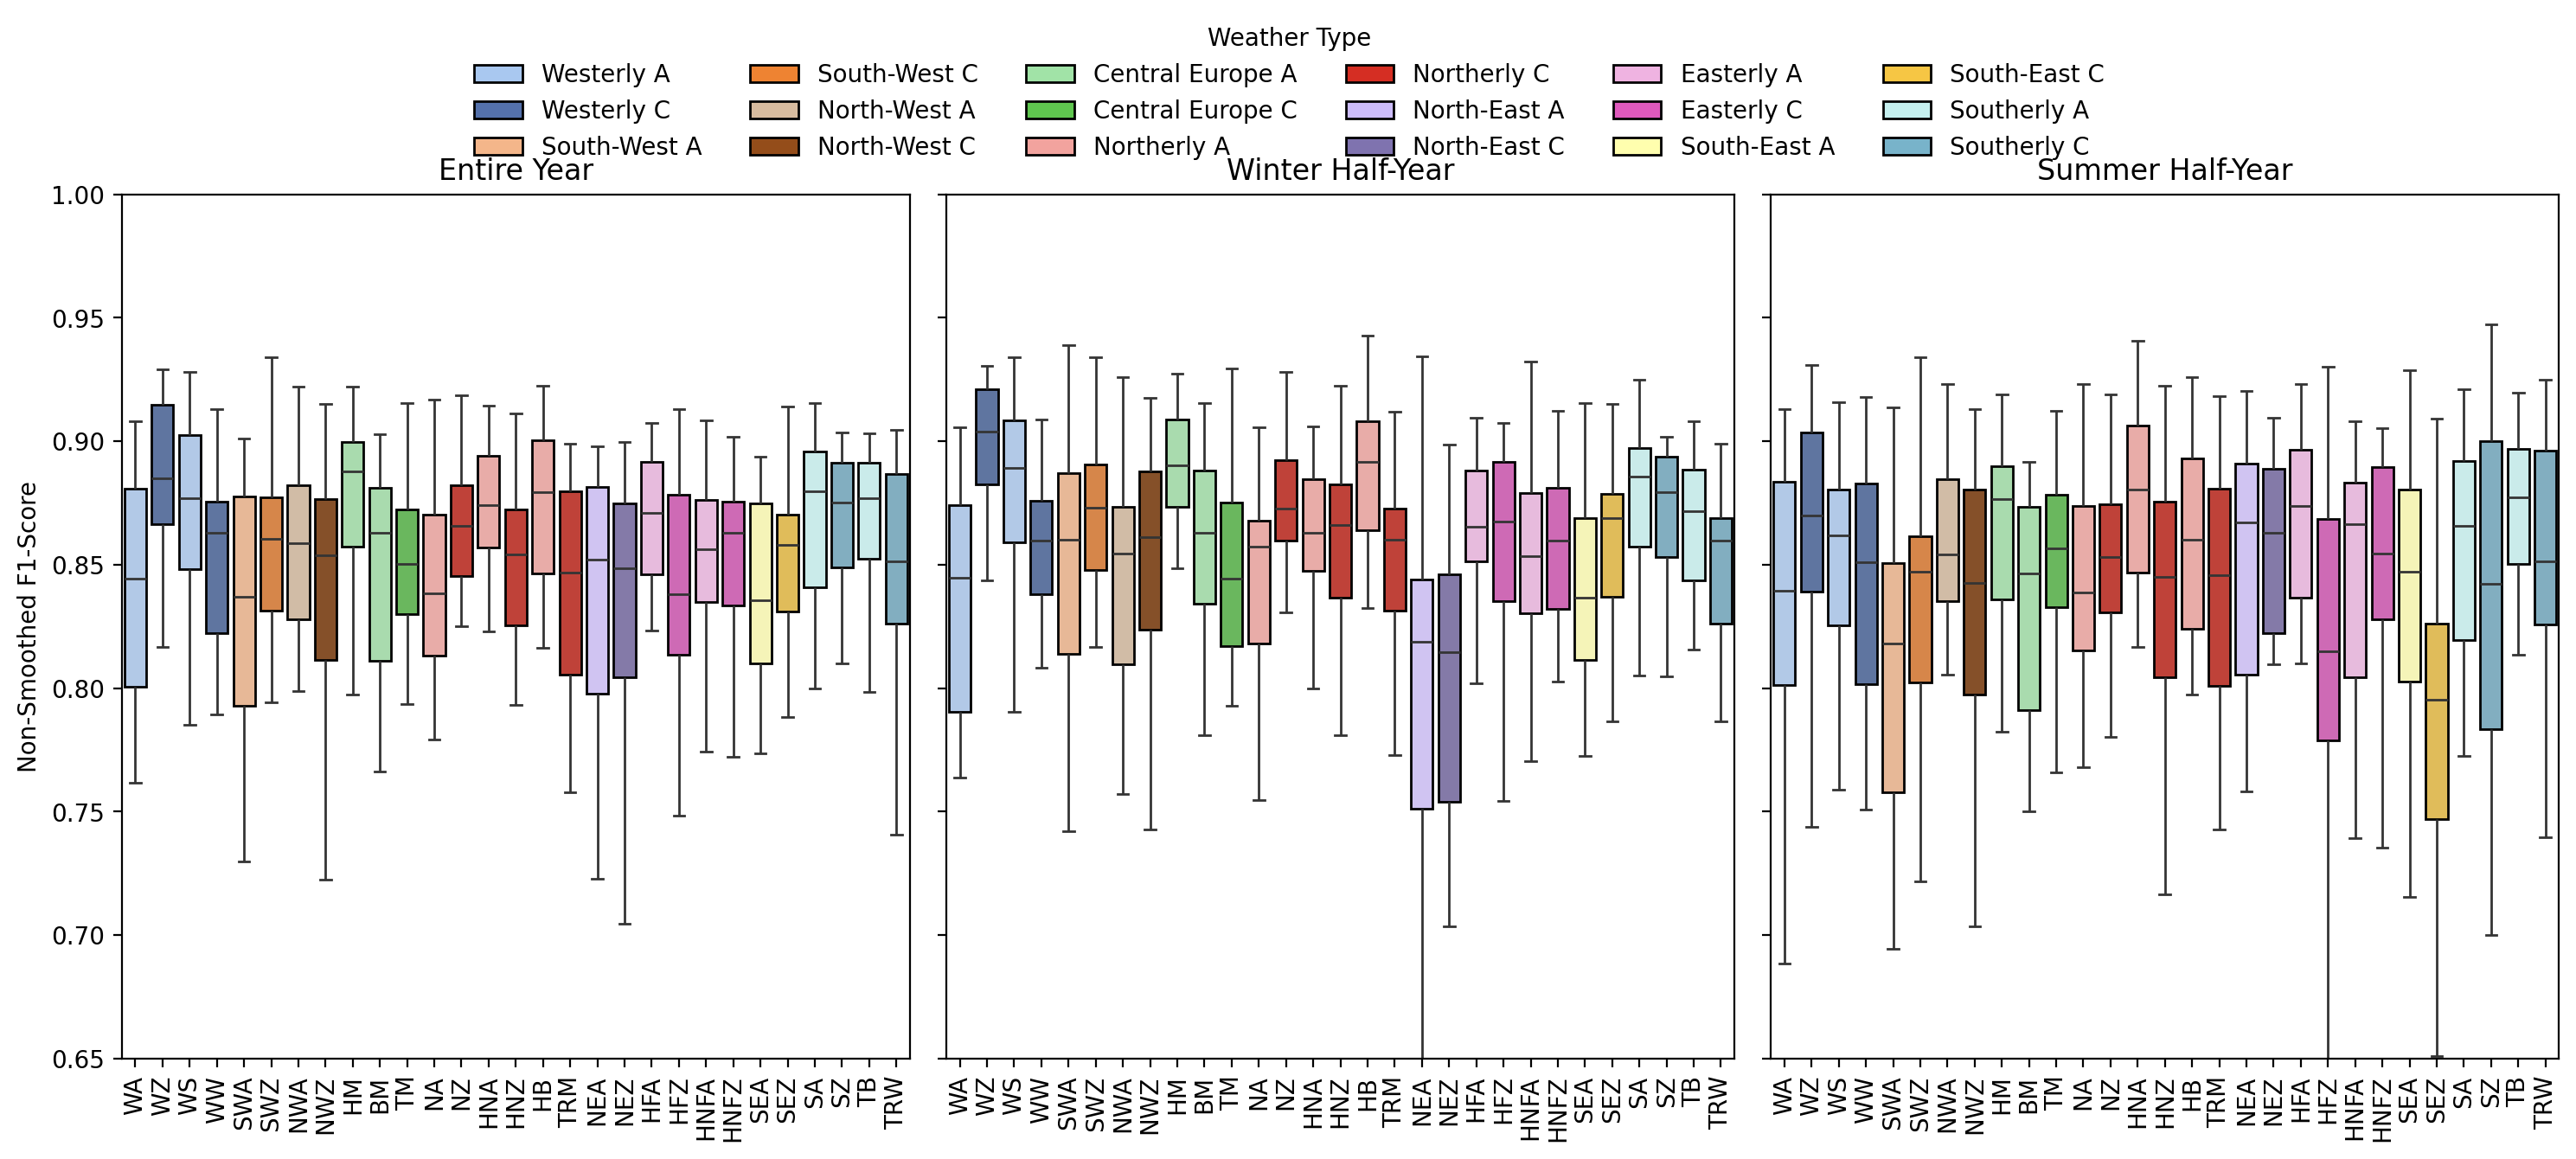

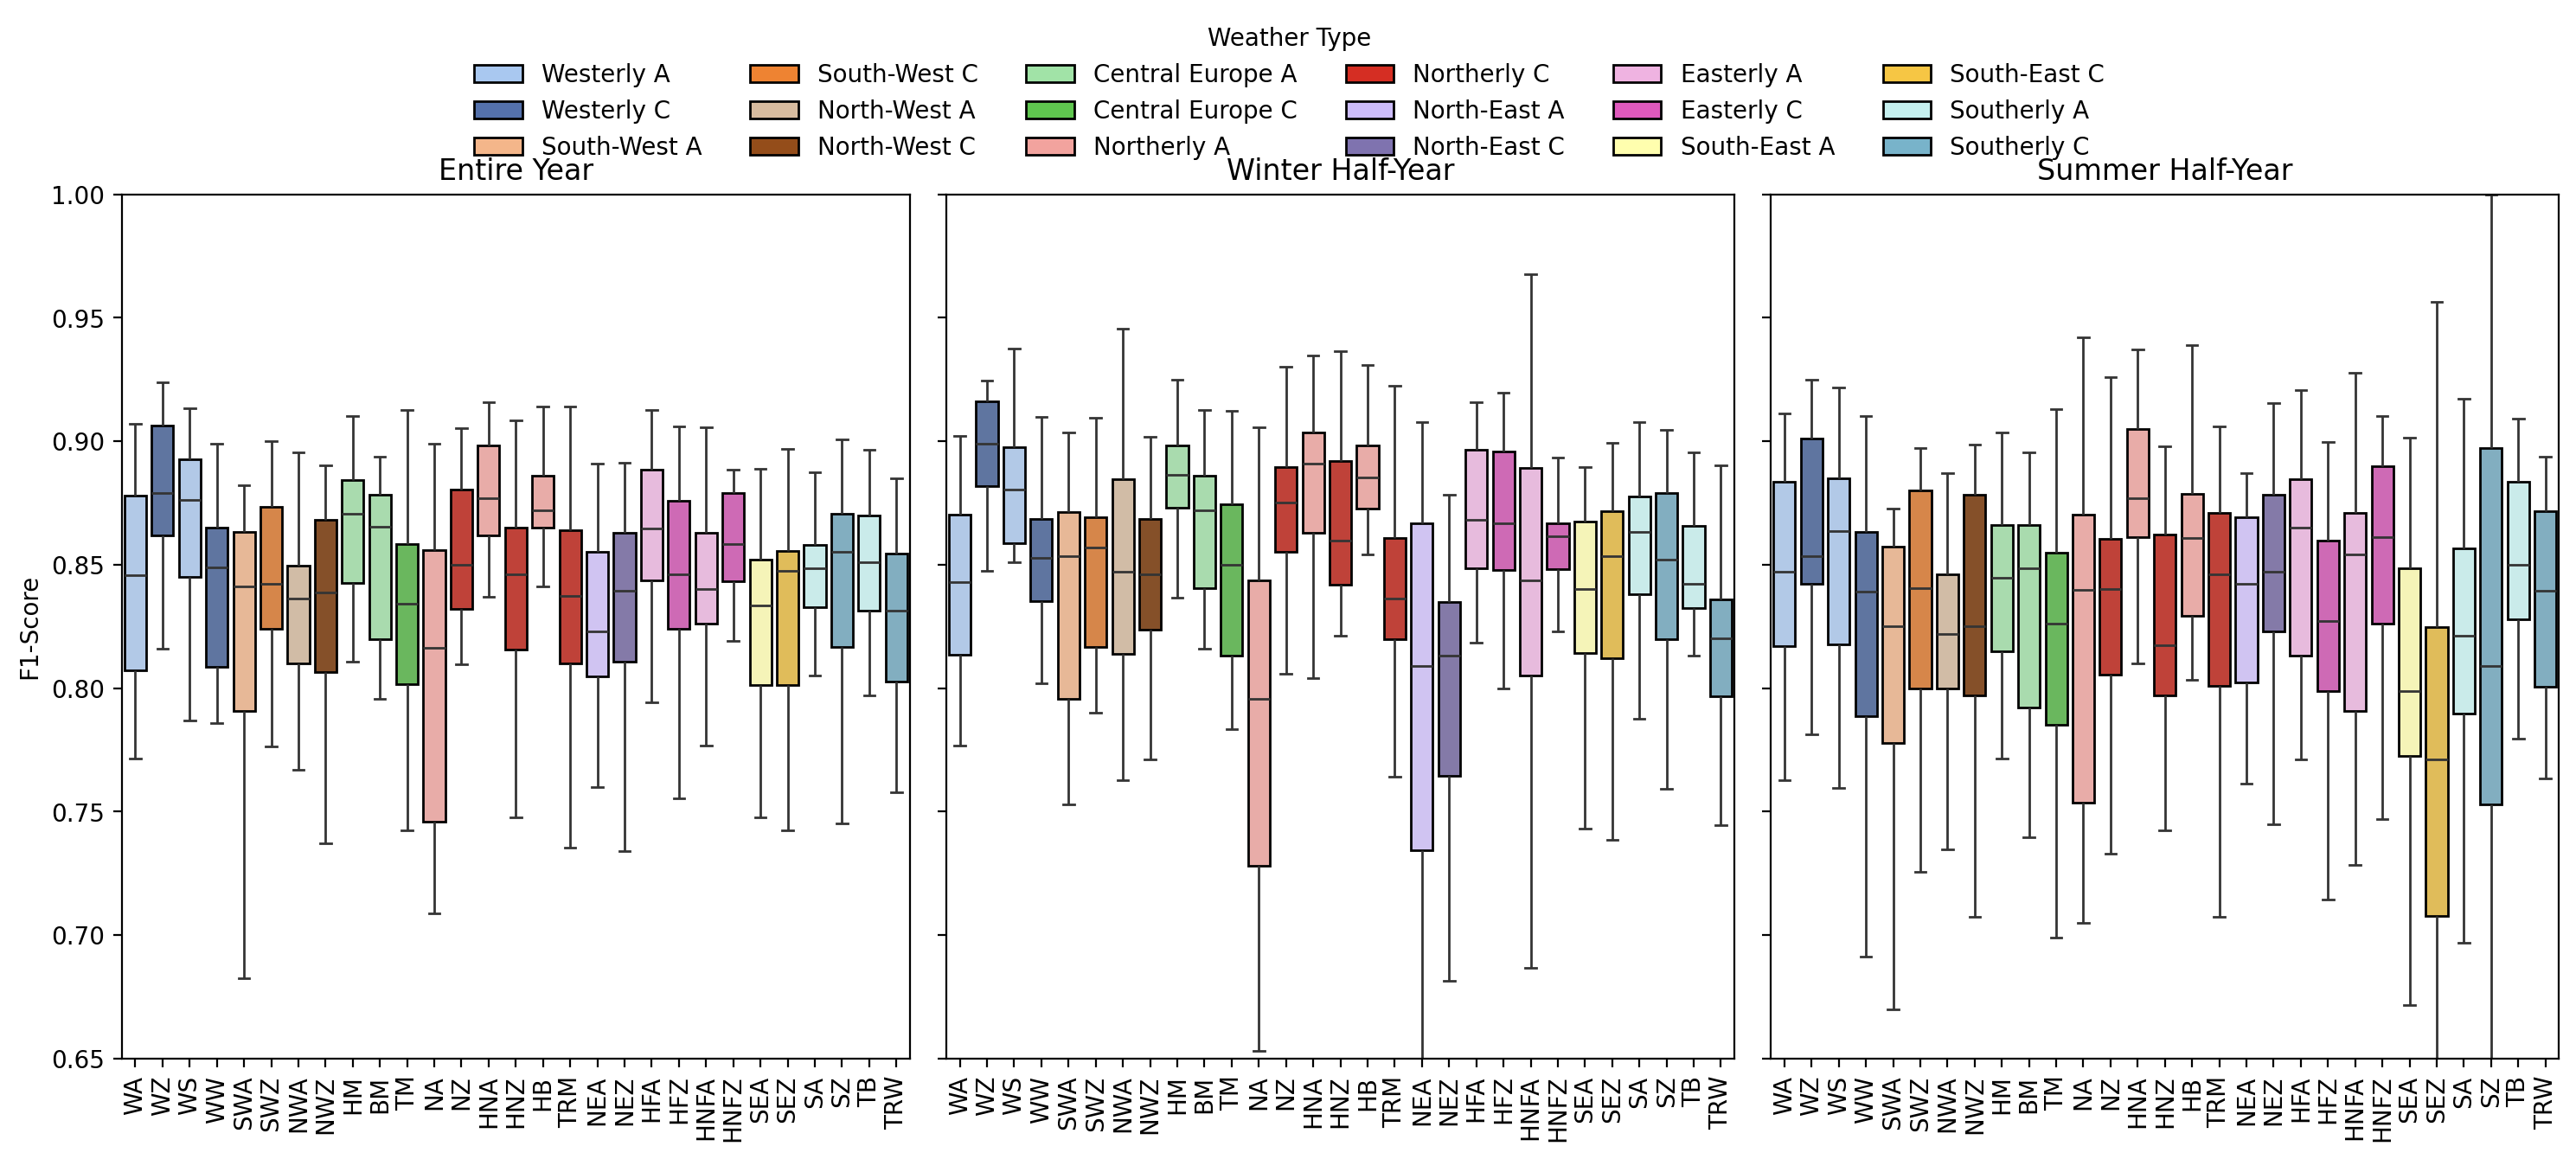

In [18]:
# Compute F1-Scores (Entire Year, Winter, Summer)

# Get seasonal indices
times = np.load(os.path.join(pro_data_path, "clean_time_1950_1980.npy"))
labels = np.load(os.path.join(pro_data_path, "clean_gwl_1950_1980_lbl.npy"))
y_tr = list(map(lbl_2_idx.get, labels))
y_tr = np.array(y_tr)
valid_month_past = times.astype('datetime64[M]').astype(int) % 12 + 1
winter_idx = np.isin(valid_month_past, winter_months)
summer_idx = np.isin(valid_month_past, summer_months)

# Per Model (for Box Plot)
f1_m = []
f1_m_smooth = []
f1_winter_m = []
f1_winter_m_smooth = []
f1_summer_m = []
f1_summer_m_smooth = []


for en in range(30):
    model_probs = boxplot_each[en]
    preds_fold = np.argmax(model_probs, axis=1)
    smoothed_preds = transition_smoothing(preds_fold, model_probs)
    
    f1_i = f1_score(y_tr, preds_fold, average=None)
    f1_winter_i = f1_score(y_tr[winter_idx], preds_fold[winter_idx], average=None)
    f1_summer_i = f1_score(y_tr[summer_idx], preds_fold[summer_idx], average=None)

    f1_m.append(f1_i)
    f1_winter_m.append(f1_winter_i)
    f1_summer_m.append(f1_summer_i)

    f1_i_s = f1_score(y_tr, smoothed_preds, average=None)
    f1_winter_i_s = f1_score(y_tr[winter_idx], smoothed_preds[winter_idx], average=None)
    f1_summer_i_s = f1_score(y_tr[summer_idx], smoothed_preds[summer_idx], average=None)

    f1_m_smooth.append(f1_i_s)
    f1_winter_m_smooth.append(f1_winter_i_s)
    f1_summer_m_smooth.append(f1_summer_i_s)


f1_m = np.array(f1_m)
f1_winter_m = np.array(f1_winter_m)
f1_summer_m = np.array(f1_summer_m)

f1_m_smooth = np.array(f1_m_smooth)
f1_winter_m_smooth = np.array(f1_winter_m_smooth)
f1_summer_m_smooth = np.array(f1_summer_m_smooth)

# Ensure Class Order Consistency
f1_order = [class_str.index(lbl) for lbl in label_order]

f1_m = f1_m[:, f1_order]
f1_winter_m = f1_winter_m[:, f1_order]
f1_summer_m = f1_summer_m[:, f1_order]

f1_m_smooth = f1_m_smooth[:, f1_order]
f1_winter_m_smooth = f1_winter_m_smooth[:, f1_order]
f1_summer_m_smooth = f1_summer_m_smooth[:, f1_order]

# Plot F1-Score Box Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, f1_data, title in zip(
    axes,
    [f1_m, f1_winter_m, f1_summer_m],
    ["Entire Year", "Winter Half-Year", "Summer Half-Year"]
):
    _= sns.boxplot(data=f1_data, ax=ax, showfliers=False, palette=palette,
            boxprops=dict(edgecolor="black"))
    _= ax.set_xticks(range(num_classes))
    _= ax.set_xticklabels(label_order, rotation=90)
    _= ax.set_title(title)
    _= ax.set_ylabel("Non-Smoothed F1-Score")
    _= ax.set_ylim(0.65, 1)

legend_types = list(class_colors.keys())
legend_patches = [
    Patch(facecolor=class_colors[wt], edgecolor='black', label=wt)
    for wt in legend_types
]
_= fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=6,
    frameon=False, fontsize='medium', title="Weather Type", title_fontsize='medium')

plt.tight_layout()
plt.savefig(os.path.join(plot_path, "non_s_boxplot_f1_scores.png"), dpi=300, bbox_inches="tight")
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, f1_data, title in zip(
    axes,
    [f1_m_smooth, f1_winter_m_smooth, f1_summer_m_smooth],
    ["Entire Year", "Winter Half-Year", "Summer Half-Year"]
):
    _= sns.boxplot(data=f1_data, ax=ax, showfliers=False, palette=palette,
            boxprops=dict(edgecolor="black"))
    _= ax.set_xticks(range(num_classes))
    _= ax.set_xticklabels(label_order, rotation=90)
    _= ax.set_title(title)
    _= ax.set_ylabel("F1-Score")
    _= ax.set_ylim(0.65, 1)

legend_types = list(class_colors.keys())
legend_patches = [
    Patch(facecolor=class_colors[wt], edgecolor='black', label=wt)
    for wt in legend_types
]
_= fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=6,
    frameon=False, fontsize='medium', title="Weather Type", title_fontsize='medium')

plt.tight_layout()
plt.savefig(os.path.join(plot_path, "boxplot_f1_scores.png"), dpi=300, bbox_inches="tight")
plt.show()

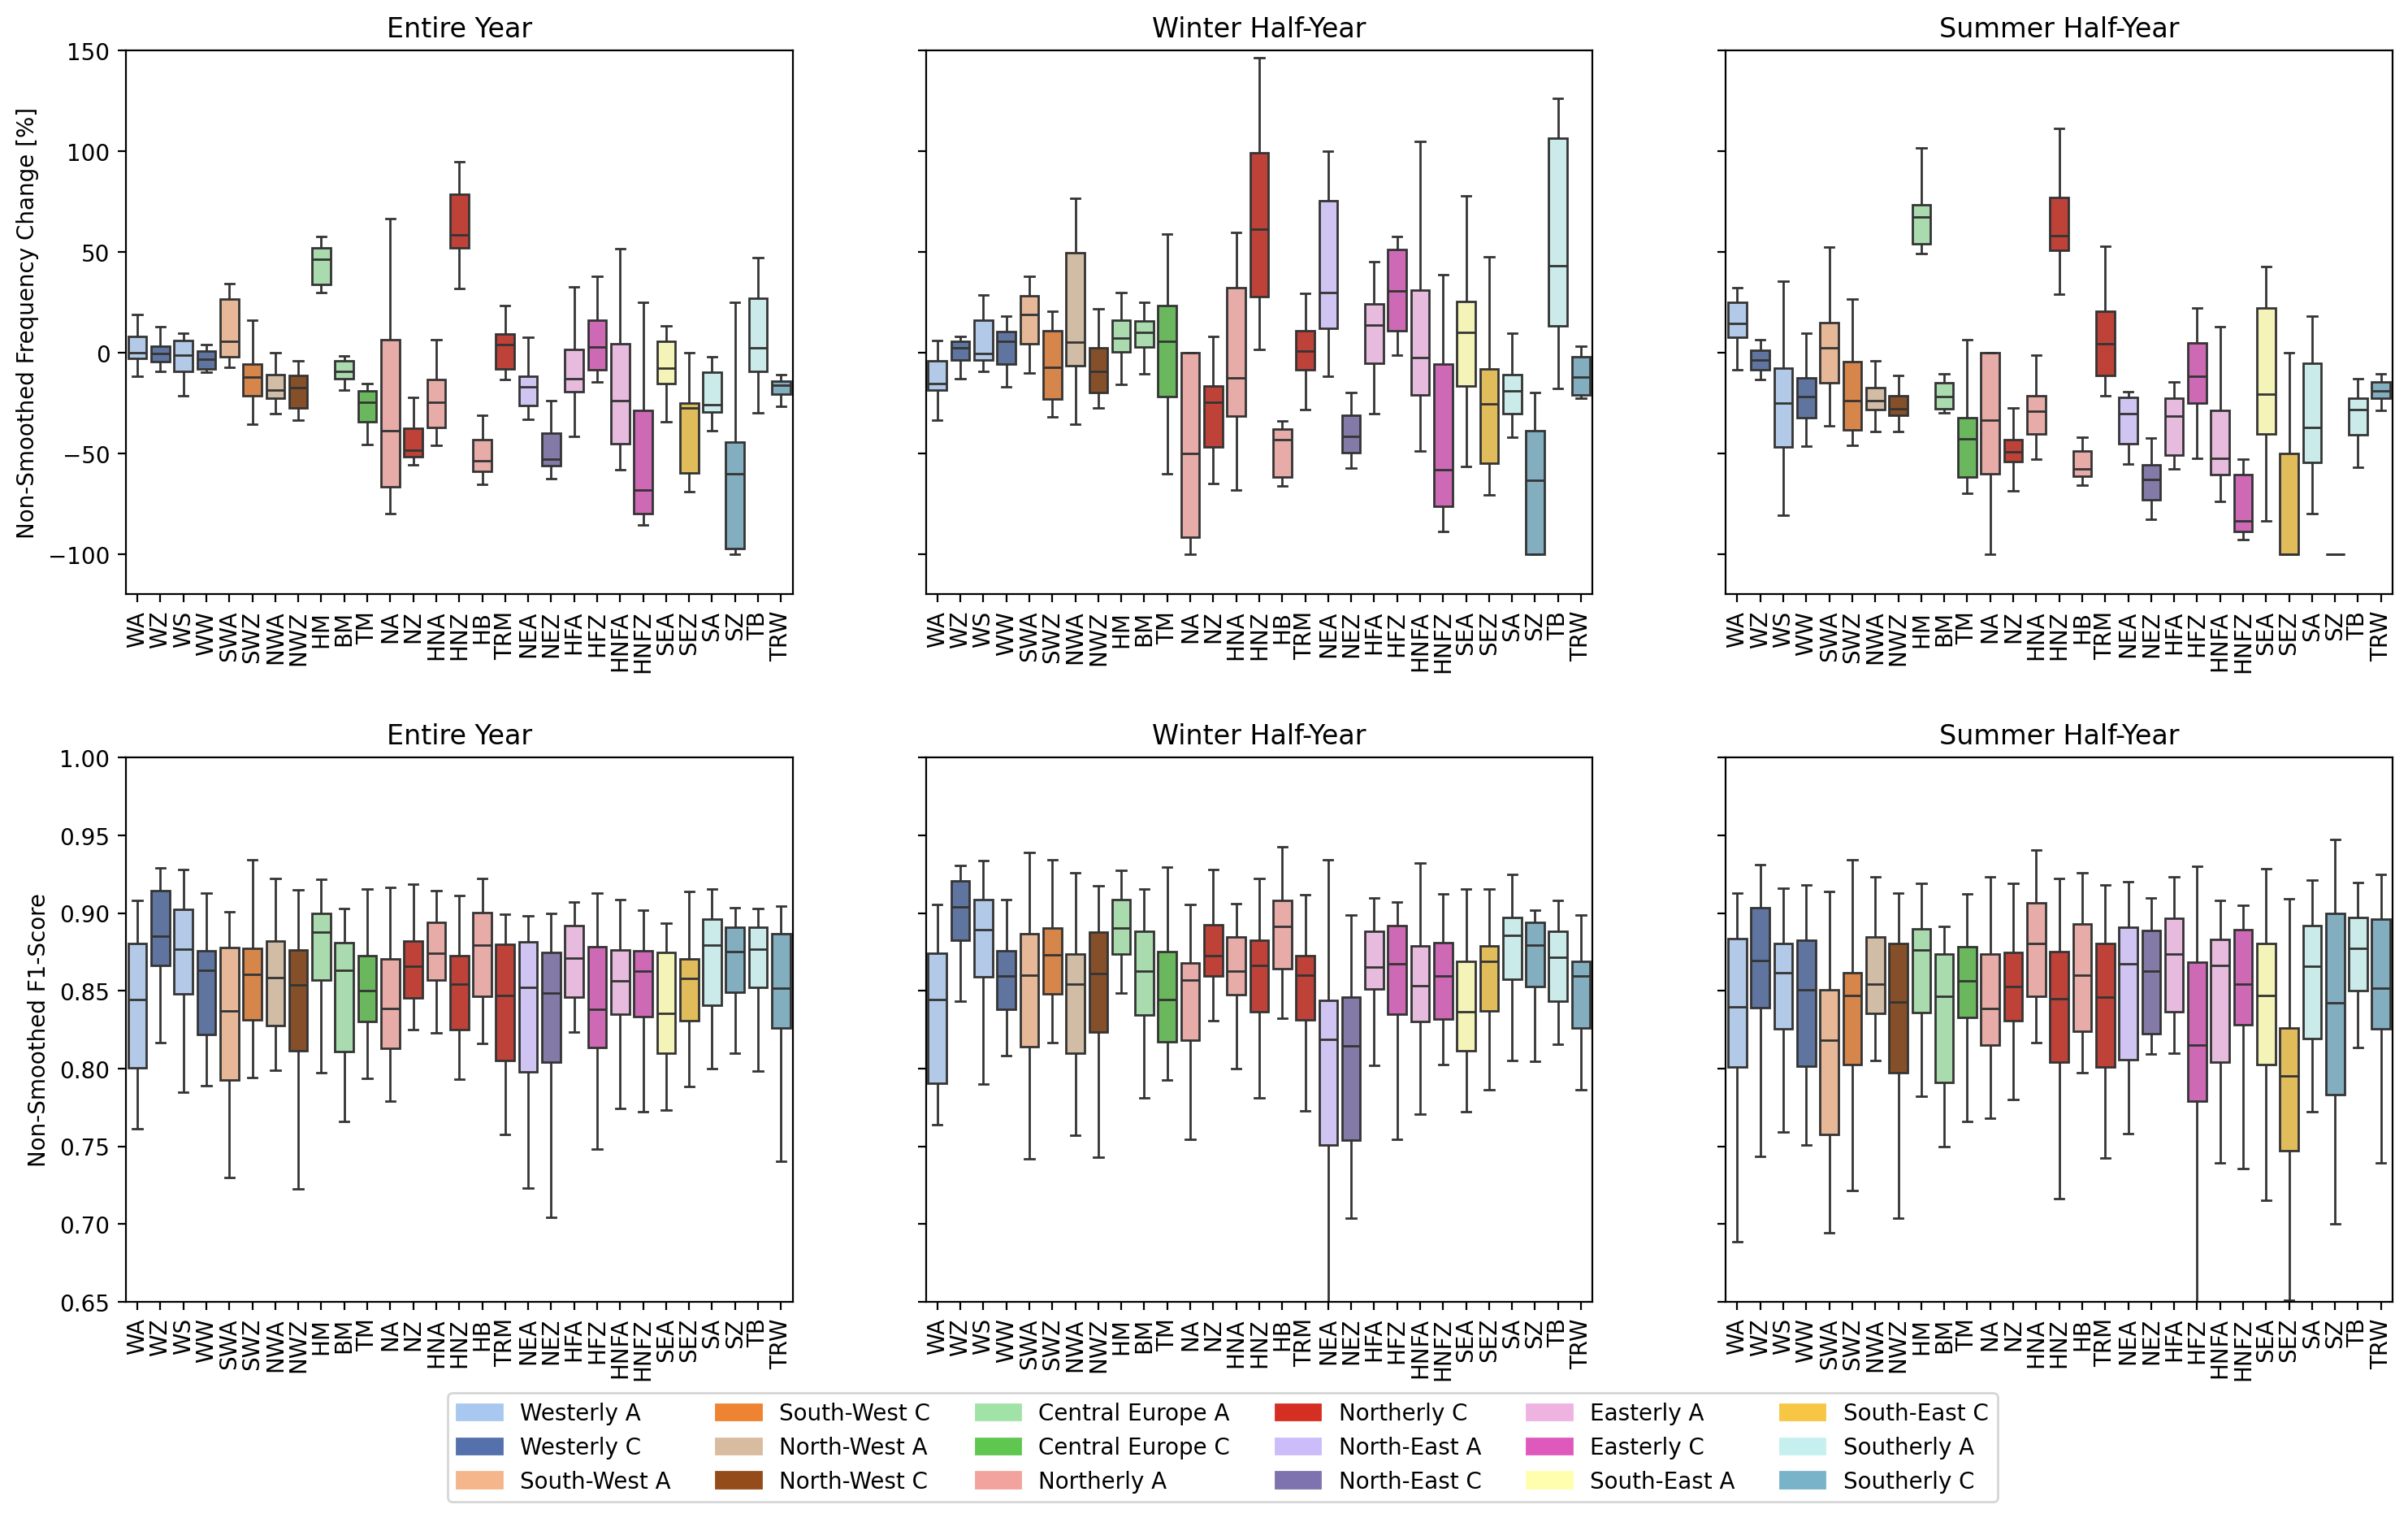

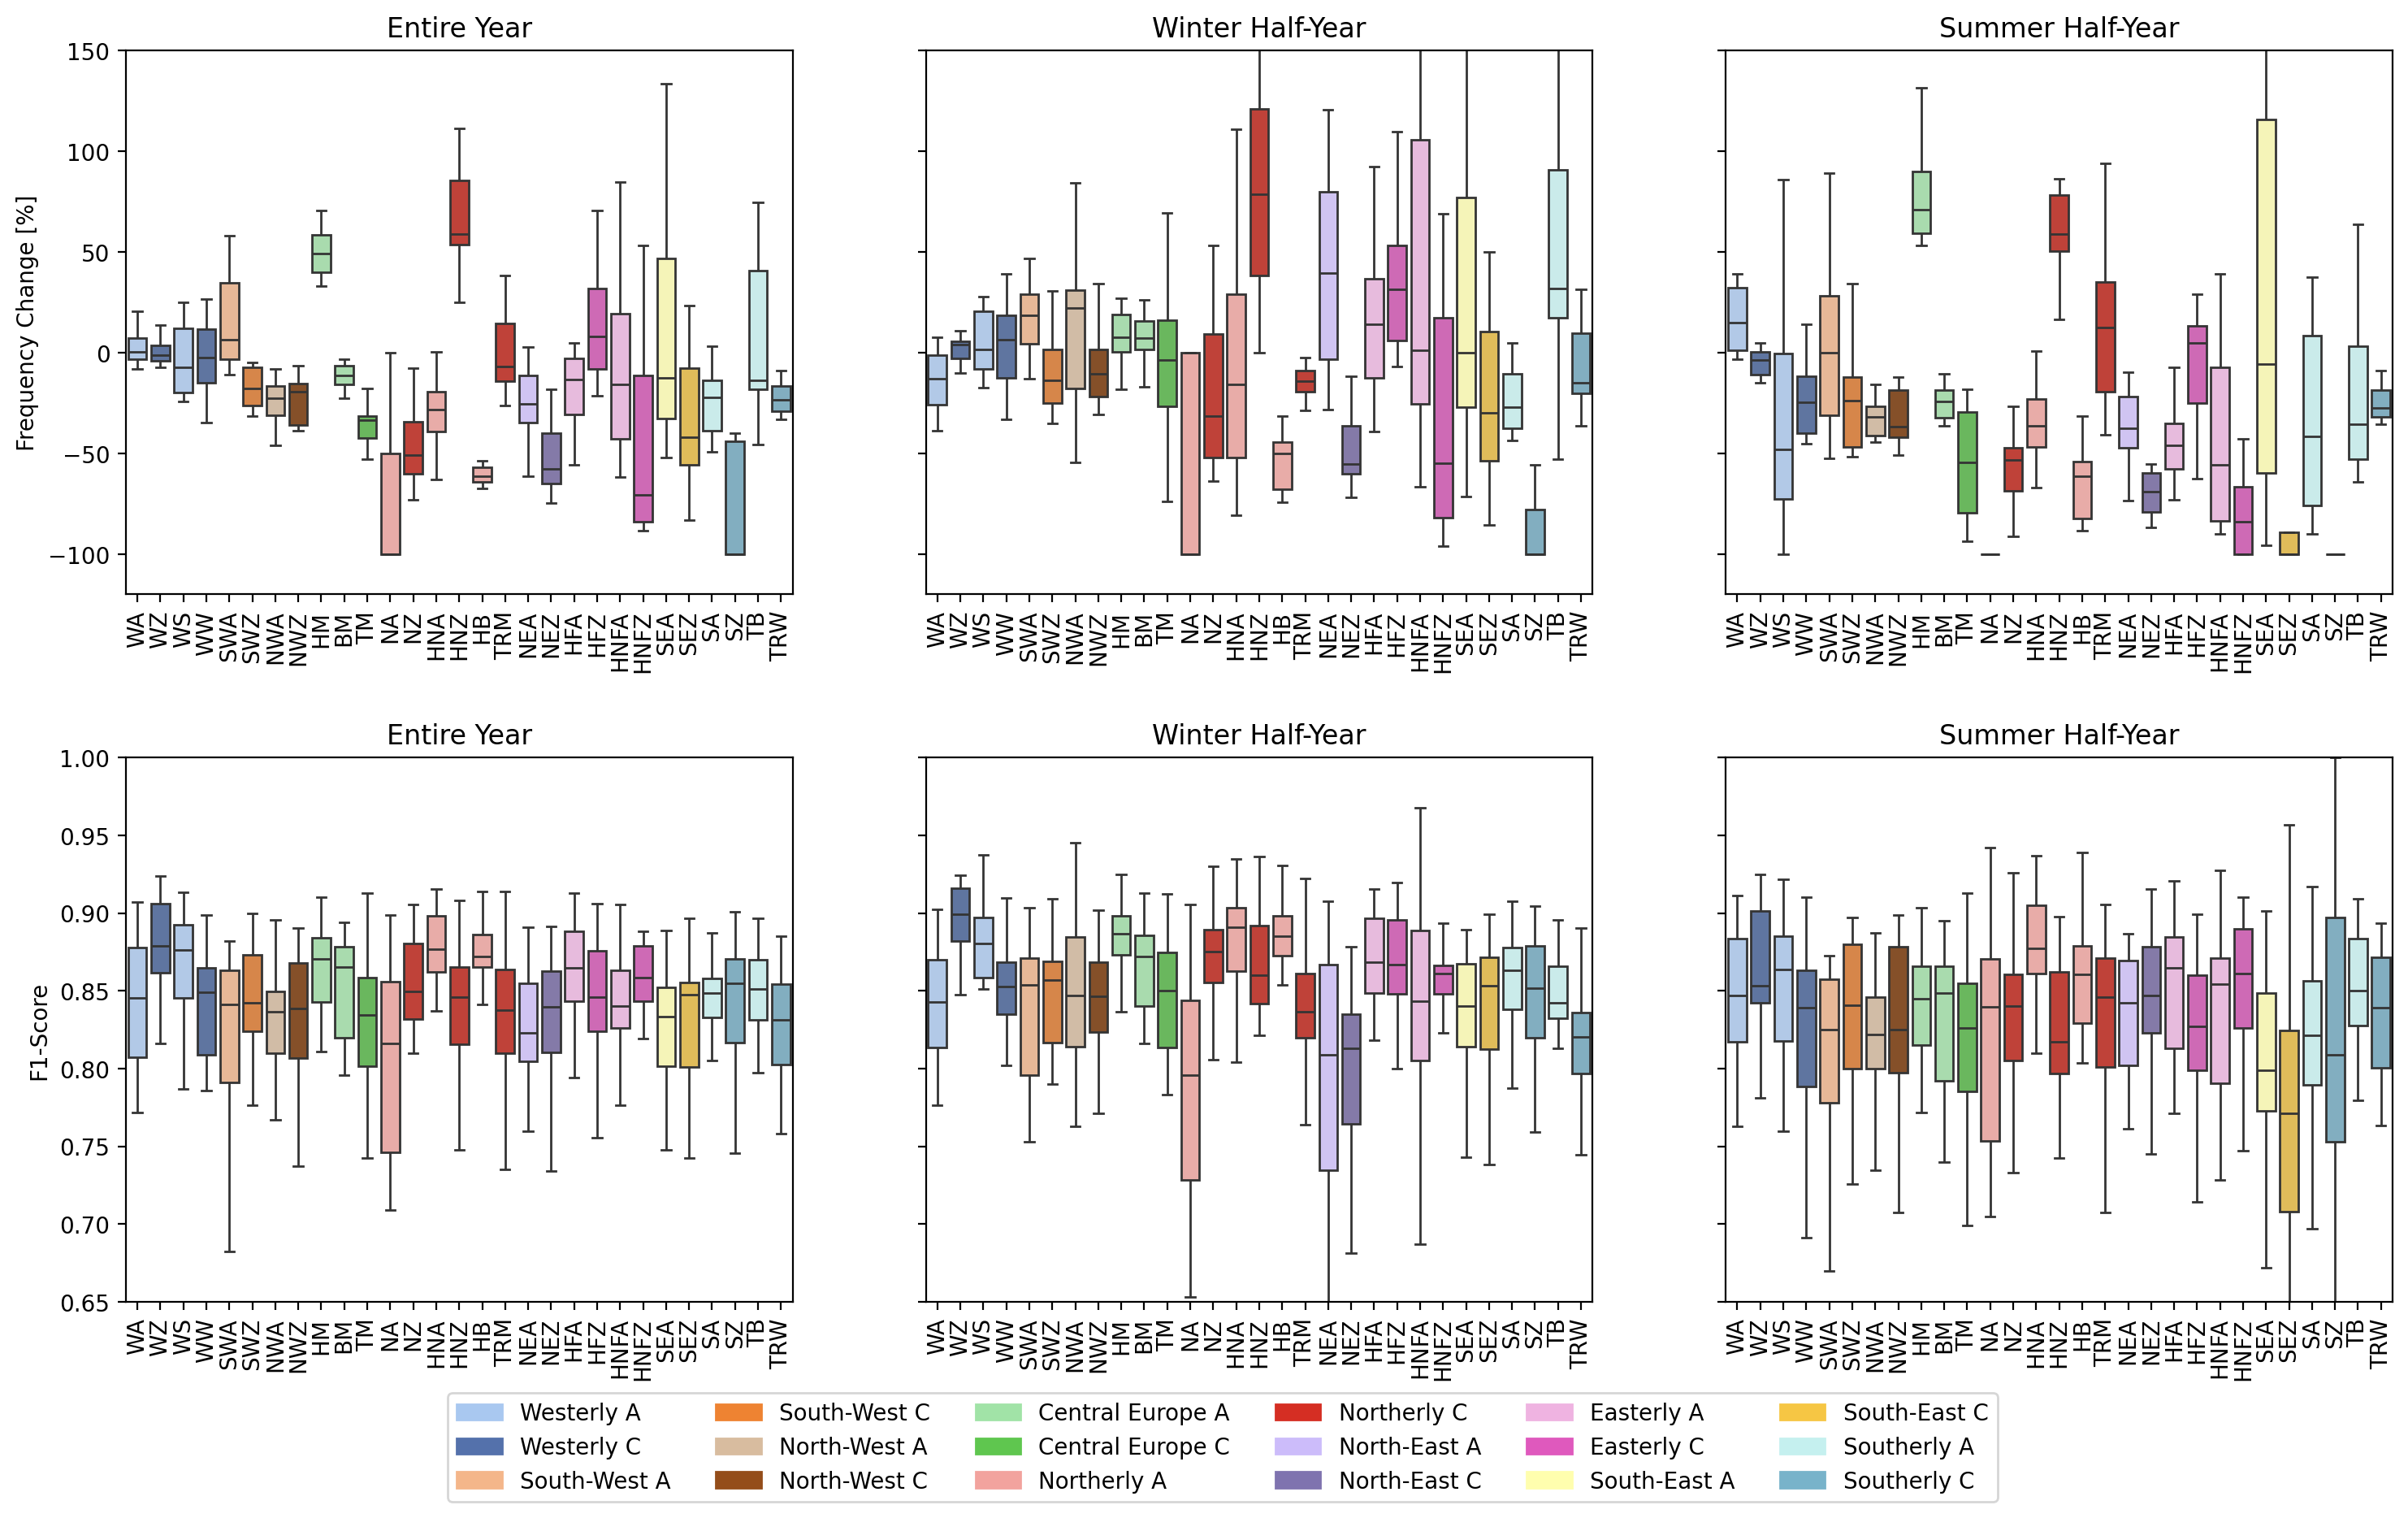

In [19]:
# --- PLOT ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey="row", gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

# Data for Frequency Change (top row)
freq_data = [freq_change, freq_change_winter, freq_change_summer]
freq_data_smooth = [freq_change_smooth, freq_change_winter_smooth, freq_change_summer_smooth]
titles_freq = ["Entire Year", "Winter Half-Year", "Summer Half-Year"]

# Data for F1-Score (bottom row)
f1_data = [f1_m, f1_winter_m, f1_summer_m]
f1_data_smooth = [f1_m_smooth, f1_winter_m_smooth, f1_summer_m_smooth]
titles_f1 = ["Entire Year", "Winter Half-Year", "Summer Half-Year"]

for i, (freq_box, f1_box) in enumerate(zip(freq_data, f1_data)):
    # --- Frequency Change Box Plot ---
    ax1 = axes[0, i]
    _= sns.boxplot(data=freq_box, ax=ax1, palette=palette, showfliers=False)
    _= ax1.set_xticks(range(len(label_order)))
    _= ax1.set_xticklabels(label_order, rotation=90)
    _= ax1.set_title(titles_freq[i])
    _= ax1.set_ylabel("Non-Smoothed Frequency Change [%]")
    _= ax1.set_ylim(-120, 150)

    # --- F1-Score Box Plot ---
    ax2 = axes[1, i]
    _= sns.boxplot(data=f1_box, ax=ax2, palette=palette, showfliers=False)
    _= ax2.set_xticks(range(len(label_order)))
    _= ax2.set_xticklabels(label_order, rotation=90)
    _= ax2.set_title(titles_f1[i])
    _= ax2.set_ylabel("Non-Smoothed F1-Score")
    _= ax2.set_ylim(0.65, 1)

# Add Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in class_colors.items()]
_= fig.legend(handles=handles, loc="lower center", ncol=6, bbox_to_anchor=(0.5, -0.02))

_= plt.tight_layout()
_= plt.savefig(os.path.join(plot_path, "non_s_combined_boxplot.png"), dpi=300, bbox_inches="tight")
plt.show()


# --- PLOT ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey="row", gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

for i, (freq_box, f1_box) in enumerate(zip(freq_data_smooth, f1_data_smooth)):
    # --- Frequency Change Box Plot ---
    ax1 = axes[0, i]
    _= sns.boxplot(data=freq_box, ax=ax1, palette=palette, showfliers=False)
    _= ax1.set_xticks(range(len(label_order)))
    _= ax1.set_xticklabels(label_order, rotation=90)
    _= ax1.set_title(titles_freq[i])
    _= ax1.set_ylabel("Frequency Change [%]")
    _= ax1.set_ylim(-120, 150)

    # --- F1-Score Box Plot ---
    ax2 = axes[1, i]
    _= sns.boxplot(data=f1_box, ax=ax2, palette=palette, showfliers=False)
    _= ax2.set_xticks(range(len(label_order)))
    _= ax2.set_xticklabels(label_order, rotation=90)
    _= ax2.set_title(titles_f1[i])
    _= ax2.set_ylabel("F1-Score")
    _= ax2.set_ylim(0.65, 1)

# Add Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in class_colors.items()]
_= fig.legend(handles=handles, loc="lower center", ncol=6, bbox_to_anchor=(0.5, -0.02))

_= plt.tight_layout()
_= plt.savefig(os.path.join(plot_path, "combined_boxplot.png"), dpi=300, bbox_inches="tight")
plt.show()